In [1]:
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# Data Loader

In [390]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

transform = Compose([
    Resize((64, 64)), 
    ToTensor(),        
    Normalize(mean=[0.5], std=[0.5])  
])

dataset_path = './Data'  
dataset = ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_set_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_set_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# Data Visualisation 

Training Data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

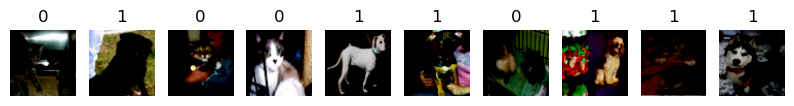

Testing Data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

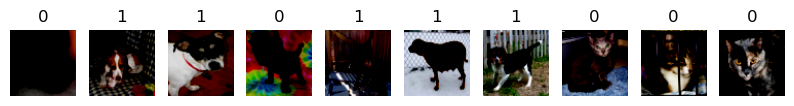

In [391]:
import matplotlib.pyplot as plt

def show_images(dataloader):
    
    for images, labels in dataloader:
        plt.figure(figsize=(10, 10))  
        for i in range(10, 20): 
            plt.subplot(1, 10, i - 9)
            plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  
            plt.title(labels[i].item())  
            plt.axis('off')  
        plt.show()
        break  

print("Training Data:")
show_images(train_set_loader)

print("Testing Data:")
show_images(test_set_loader)


# Training and testing modules

In [392]:
def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    model.train()
    accuracies = []  # Store accuracy values
    
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            accuracies.append(correct)  # Store accuracy
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
    
    return accuracies

In [393]:
def train_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    accuracies = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    
    plot_accuracies(accuracies)

In [394]:
def test(model, device, test_set_loader):

    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f},\n Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")

In [395]:
def plot_accuracies(accuracies):
    plt.plot(accuracies)
    plt.title('Accuracy Changes During Training')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.show()


In [396]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating the Spiking neuron model

In [397]:
class RNN_Spiking_Neuron(nn.Module):
    
    def __init__(self, computation_device, n_inputs=64*64, n_hidden=100, decay_multiplier=0.9, 
                 threshold=2.0, penalty_threshold=2.5):
        super(RNN_Spiking_Neuron, self).__init__()
        self.computation_device = computation_device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.computation_device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.computation_device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.computation_device)

    def forward(self, x):
    
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])

        input_excitation = self.fc(x)
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        outer_excitation = F.relu(inner_excitation - self.threshold)
        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * 
                                               inner_excitation) * do_penalize_gate
        outer_excitation = outer_excitation
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output

# Input Encoder

In [398]:
class Input_layer(nn.Module):
    
    def __init__(self, computation_device):
        super(Input_layer, self).__init__()
        self.computation_device = computation_device
        
        self.reset_state()
        self.to(self.computation_device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.computation_device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1) 
        random_activation_perceptron = torch.rand(x.shape).to(self.computation_device)
        return random_activation_perceptron * x


# Output Decoder

In [399]:
class Output_layer(nn.Module):
    
    def __init__(self, average_output=True):
      
        super(Output_layer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


# The Spiking Neural Network Module

In [400]:

class Pulse_Network(nn.Module):
    def __init__(self, computation_device, n_time_steps, begin_eval):
        super(Pulse_Network, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.computation_device = computation_device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(computation_device)
        
        self.layer1 = RNN_Spiking_Neuron(
            computation_device, n_inputs=64*64*3, n_hidden=100,  
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            computation_device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False) 
        
        self.to(self.computation_device)

    
    def forward_through_time(self, x):
 
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)

            layer1_state, layer1_output = self.layer1(xi)
          
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)
   
    def Display_neurons(self, x, width=None, height=None):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

            self.plot_layer(layer_state, title="Values of the internal state neurons for layer {}".format(i), width=width, height=height)
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i), width=width, height=height)
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Values of the internal state of neuron {} in layer {}.".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Activation values (spikes) of neuron {} in layer {}.".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title, width=None, height=None):
        if width is None:
            width = max(5, layer_values.shape[0] / 8)
        if height is None:
            height = max(5, layer_values.shape[1] / 8)

        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(5, len(neuron_through_time) / 8)
        height = 5
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.grid(True)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()



# Initialise The Training Of A 2-Layer SNN model

Train Epoch: 1 [0/19998 (0%)] Loss: 2.863985 Accuracy: 1.56%
Train Epoch: 1 [1280/19998 (6%)] Loss: 0.747765 Accuracy: 42.97%
Train Epoch: 1 [2560/19998 (13%)] Loss: 0.816925 Accuracy: 41.41%
Train Epoch: 1 [3840/19998 (19%)] Loss: 0.651727 Accuracy: 61.72%
Train Epoch: 1 [5120/19998 (25%)] Loss: 0.680837 Accuracy: 55.47%
Train Epoch: 1 [6400/19998 (32%)] Loss: 0.709546 Accuracy: 49.22%
Train Epoch: 1 [7680/19998 (38%)] Loss: 0.681057 Accuracy: 57.81%
Train Epoch: 1 [8960/19998 (45%)] Loss: 0.658570 Accuracy: 60.94%


/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [10240/19998 (51%)] Loss: 0.682533 Accuracy: 57.81%
Train Epoch: 1 [11520/19998 (57%)] Loss: 0.666777 Accuracy: 60.16%
Train Epoch: 1 [12800/19998 (64%)] Loss: 0.666867 Accuracy: 57.03%
Train Epoch: 1 [14080/19998 (70%)] Loss: 0.670310 Accuracy: 60.94%
Train Epoch: 1 [15360/19998 (76%)] Loss: 0.644252 Accuracy: 64.84%
Train Epoch: 1 [16640/19998 (83%)] Loss: 0.683358 Accuracy: 53.91%
Train Epoch: 1 [17920/19998 (89%)] Loss: 0.697154 Accuracy: 53.12%
Train Epoch: 1 [19200/19998 (96%)] Loss: 0.633477 Accuracy: 61.72%


/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0053,
 Accuracy: 3020/5000 (60.40%)

Train Epoch: 2 [0/19998 (0%)] Loss: 0.641436 Accuracy: 61.72%
Train Epoch: 2 [1280/19998 (6%)] Loss: 0.632855 Accuracy: 61.72%
Train Epoch: 2 [2560/19998 (13%)] Loss: 0.622877 Accuracy: 64.06%
Train Epoch: 2 [3840/19998 (19%)] Loss: 0.647473 Accuracy: 60.16%
Train Epoch: 2 [5120/19998 (25%)] Loss: 0.626858 Accuracy: 64.84%
Train Epoch: 2 [6400/19998 (32%)] Loss: 0.637658 Accuracy: 60.16%
Train Epoch: 2 [7680/19998 (38%)] Loss: 0.594701 Accuracy: 67.97%
Train Epoch: 2 [8960/19998 (45%)] Loss: 0.663959 Accuracy: 59.38%
Train Epoch: 2 [10240/19998 (51%)] Loss: 0.673130 Accuracy: 59.38%
Train Epoch: 2 [11520/19998 (57%)] Loss: 0.628707 Accuracy: 61.72%
Train Epoch: 2 [12800/19998 (64%)] Loss: 0.613742 Accuracy: 65.62%
Train Epoch: 2 [14080/19998 (70%)] Loss: 0.631240 Accuracy: 62.50%
Train Epoch: 2 [15360/19998 (76%)] Loss: 0.663571 Accuracy: 63.28%
Train Epoch: 2 [16640/19998 (83%)] Loss: 0.626578 Accuracy: 67.97%
Train Epoch

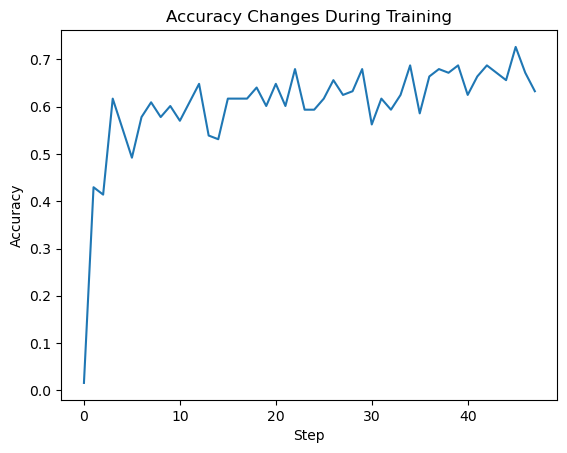

In [402]:
spiking_model_2layers = Pulse_Network(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_2layers)

# visualise the Results

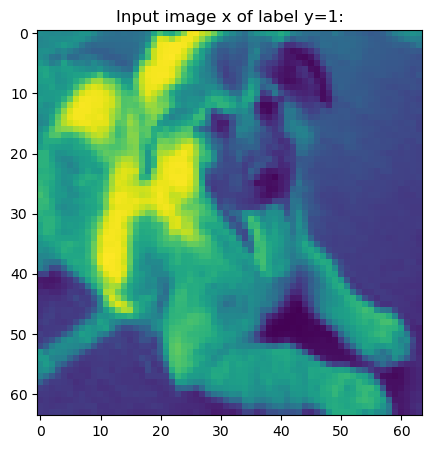

In [14]:
data, target = test_set_loader.__iter__().__next__()

x = torch.stack([data[2]]) 
y = target.data.numpy()[2]
plt.figure(figsize=(5,5))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()


# Spiking patterns of the Layers

A hidden neuron that looks excited:


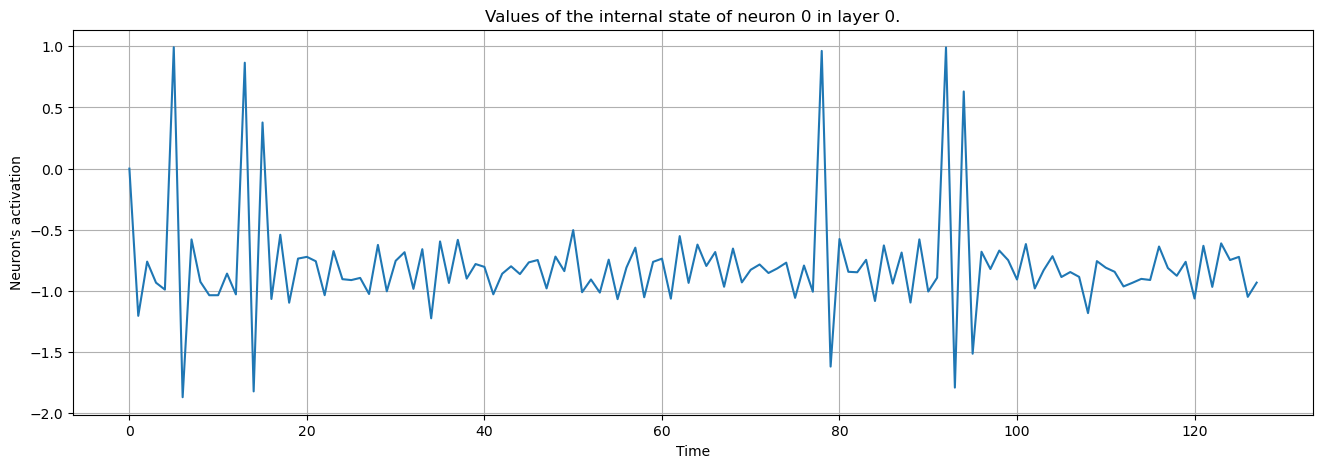

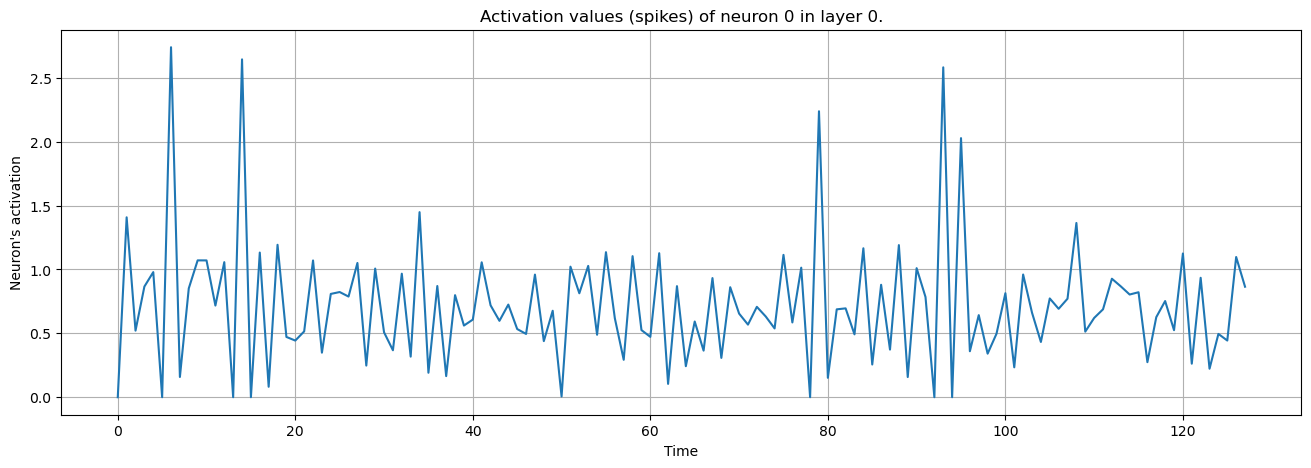

The output neuron of the label:


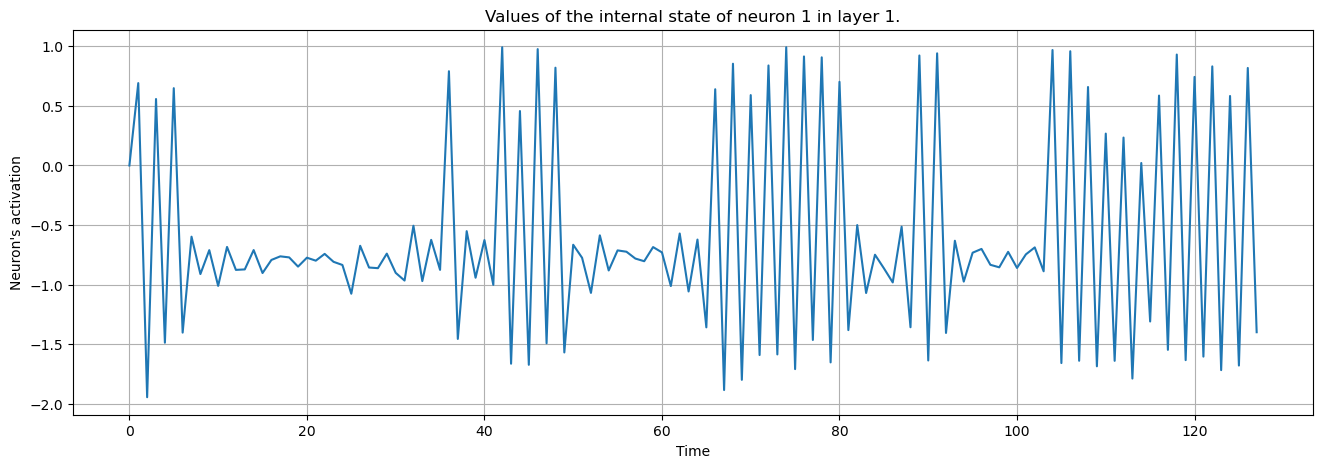

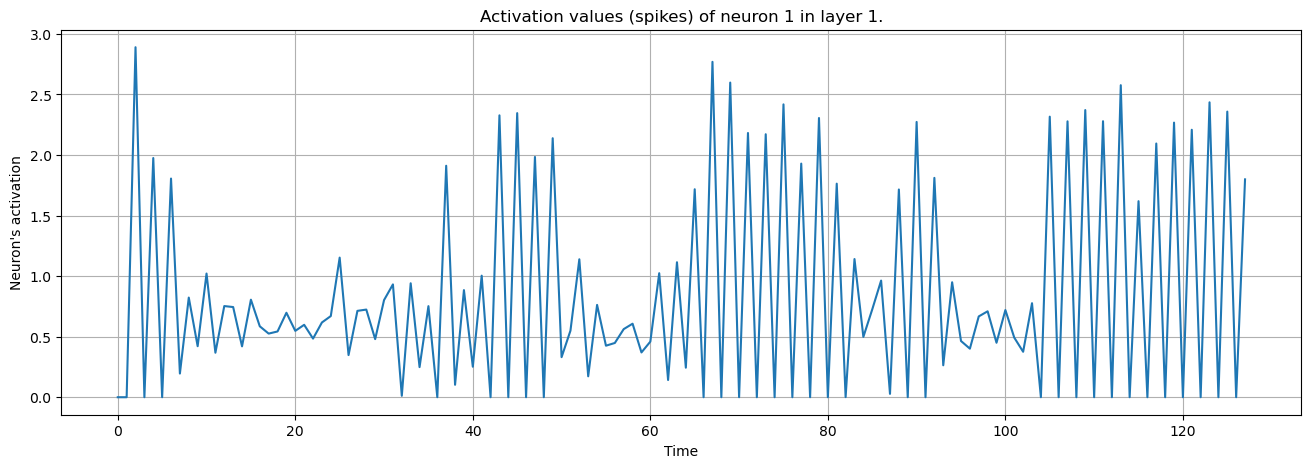

In [404]:
print("A hidden neuron that looks excited:")
spiking_model_2layers.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model_2layers.visualize_neuron(x, layer_idx=1, neuron_idx=y)

# confusion matrix for the 2 layer model


Test set: Average loss: 0.6437, Accuracy: 3184/5000 (63.68%)

Accuracy of the model: 63.68%


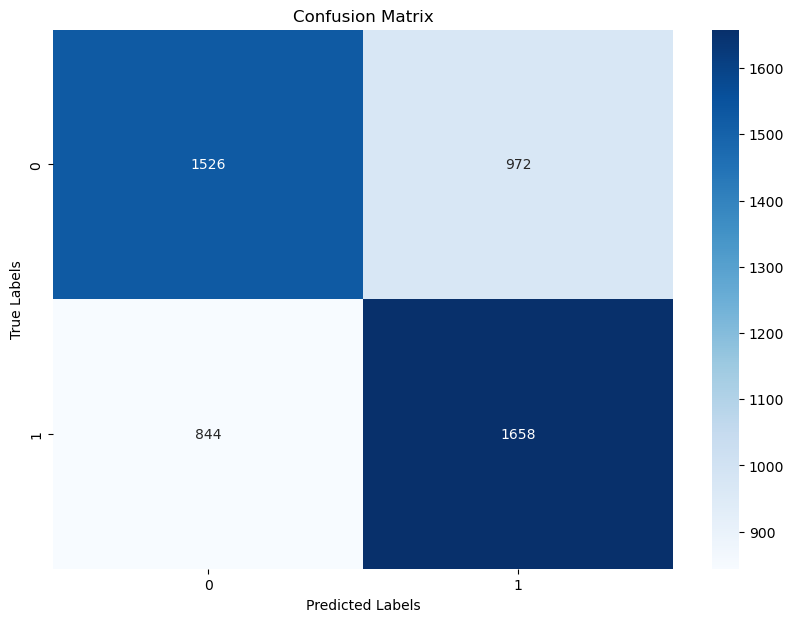

In [406]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Modify or add in your training epochs loop or testing phase
conf_matrix_2layer, accuracy_2layer = test(spiking_model_2layers, device, test_set_loader) 

print("Accuracy of the model: {:.2f}%".format(100. * accuracy_2layer))

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_2layer, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


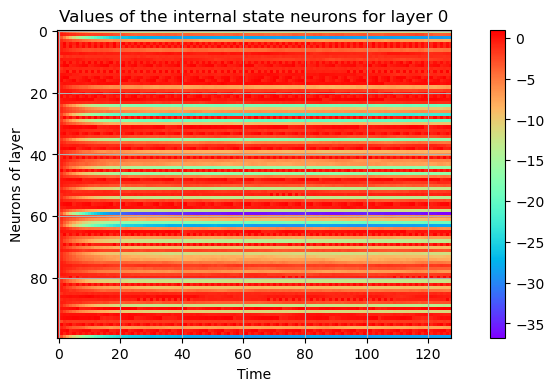

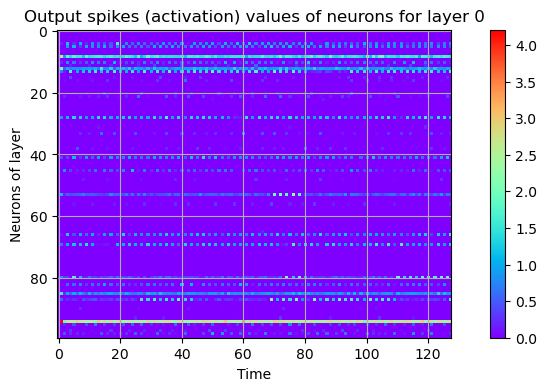

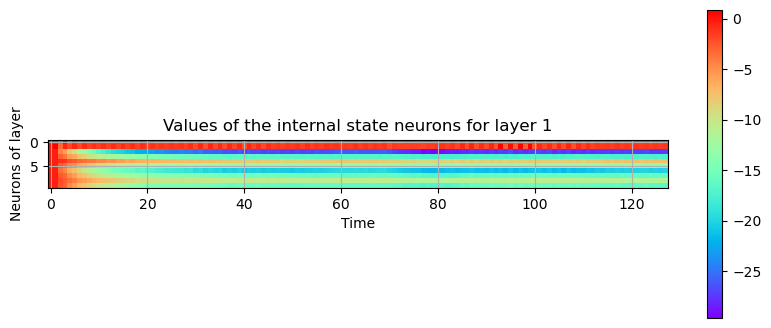

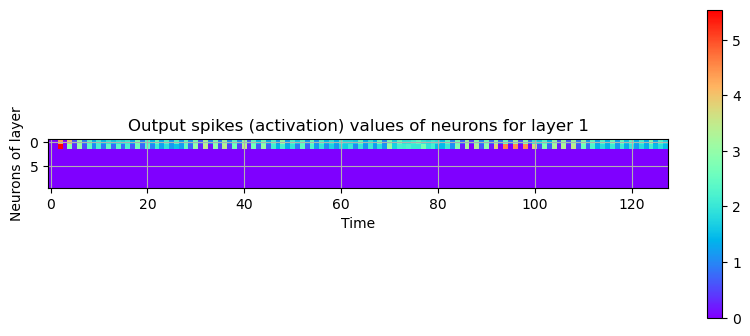

In [19]:
spiking_model_2layers.Display_neurons(x, width=10, height=4)

# Binary Classification Using 3 Layer SNN model

In [84]:


import matplotlib.pyplot as plt

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    model.train()
    accuracies = []  # Store accuracy values
    
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            accuracies.append(correct)  # Store accuracy
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
    
    return accuracies

def train_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    accuracies = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    
    plot_accuracies(accuracies)

def plot_accuracies(accuracies):
    plt.plot(accuracies)
    plt.title('Accuracy Changes During Training')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.show()

            
def test(model, device, test_set_loader):

    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")




In [85]:
class RNN_Spiking_Neuron(nn.Module):
    
    def __init__(self, computation_device, n_inputs=64*64, n_hidden=100, decay_multiplier=0.9, 
                 threshold=2.0, penalty_threshold=2.5):
        super(RNN_Spiking_Neuron, self).__init__()
        self.computation_device = computation_device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.computation_device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.computation_device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.computation_device)

    def forward(self, x):
    
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])

        input_excitation = self.fc(x)
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        outer_excitation = F.relu(inner_excitation - self.threshold)
        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * 
                                               inner_excitation) * do_penalize_gate
        outer_excitation = outer_excitation
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output

In [86]:

class Input_layer(nn.Module):
    
    def __init__(self, computation_device):
        super(Input_layer, self).__init__()
        self.computation_device = computation_device
        
        self.reset_state()
        self.to(self.computation_device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.computation_device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.computation_device)
        return random_activation_perceptron * x


In [87]:
class Output_layer(nn.Module):
    
    def __init__(self, average_output=True):
      
        super(Output_layer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


In [360]:

class Pulse_Network_3layer(nn.Module):
    def __init__(self, computation_device, n_time_steps, begin_eval):
        super(Pulse_Network_3layer, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.computation_device = computation_device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(computation_device)
        
        self.layer1 = RNN_Spiking_Neuron(
            computation_device, n_inputs=64*64*3, n_hidden=100, 
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            computation_device, n_inputs=100, n_hidden=50, 
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

      
        self.layer3 = RNN_Spiking_Neuron(
            computation_device, n_inputs=50, n_hidden=10,  
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False)  
        
        self.to(self.computation_device)
    
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state()  

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = []  
        all_layer3_outputs = []  
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # Processing through layers
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output)  
            
            # Appending states and outputs for visualization
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state) 
            all_layer3_outputs.append(layer3_output)  
            out.append(layer3_state)  
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs], [all_layer3_states, all_layer3_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)
    
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state() 

        out = []
        
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = [] 
        all_layer3_outputs = []  
        
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # Process through each layer
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output)  
            
            # Append states and outputs for each layer
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state) 
            all_layer3_outputs.append(layer3_output) 
            out.append(layer3_output)  
            
       
        out = self.output_conversion(torch.stack(out[self.begin_eval:]))
        return out, [[all_layer1_states, all_layer1_outputs], 
                     [all_layer2_states, all_layer2_outputs], 
                     [all_layer3_states, all_layer3_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)


    def Display_neurons(self, x, width=None, height=None):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network_3layer.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Values of the internal state neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network_3layer.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Values of the internal state of neuron {} in layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title, width=None, height=None):
        if width is None:
            width = max(5, layer_values.shape[0] / 8)
        if height is None:
            height = max(5, layer_values.shape[1] / 8)

        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(5, len(neuron_through_time) / 8)
        height = 5
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.grid(True)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

In [96]:
def test(model, device, test_set_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_set_loader.dataset)

    conf_matrix = confusion_matrix(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    
    return conf_matrix, accuracy


Train Epoch: 1 [0/19998 (0%)] Loss: 2.302533 Accuracy: 5.47%
Train Epoch: 1 [1280/19998 (6%)] Loss: 2.277324 Accuracy: 46.09%
Train Epoch: 1 [2560/19998 (13%)] Loss: 2.216765 Accuracy: 48.44%
Train Epoch: 1 [3840/19998 (19%)] Loss: 1.419066 Accuracy: 60.16%
Train Epoch: 1 [5120/19998 (25%)] Loss: 1.780392 Accuracy: 53.91%
Train Epoch: 1 [6400/19998 (32%)] Loss: 0.886914 Accuracy: 51.56%
Train Epoch: 1 [7680/19998 (38%)] Loss: 0.802802 Accuracy: 50.78%
Train Epoch: 1 [8960/19998 (45%)] Loss: 0.738703 Accuracy: 54.69%
Train Epoch: 1 [10240/19998 (51%)] Loss: 0.714971 Accuracy: 60.16%
Train Epoch: 1 [11520/19998 (57%)] Loss: 0.695325 Accuracy: 59.38%
Train Epoch: 1 [12800/19998 (64%)] Loss: 0.770971 Accuracy: 53.12%
Train Epoch: 1 [14080/19998 (70%)] Loss: 0.846875 Accuracy: 51.56%
Train Epoch: 1 [15360/19998 (76%)] Loss: 0.749620 Accuracy: 55.47%
Train Epoch: 1 [16640/19998 (83%)] Loss: 0.702510 Accuracy: 57.03%
Train Epoch: 1 [17920/19998 (89%)] Loss: 0.699413 Accuracy: 61.72%
Train Epo

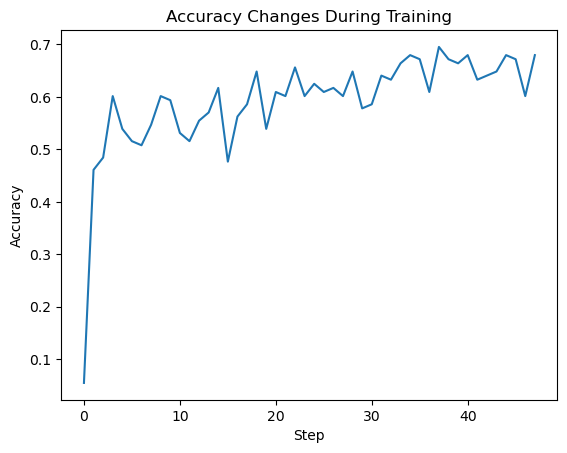

In [92]:
spiking_model_3layers = Pulse_Network_3layer(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_3layers)

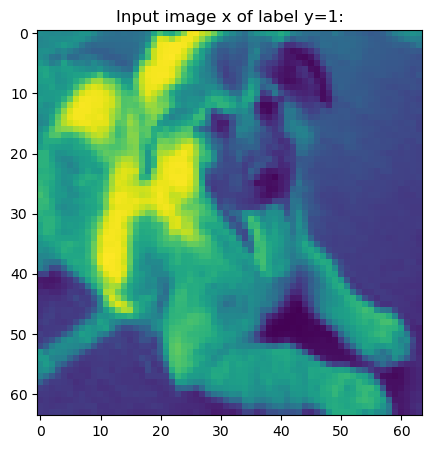

In [93]:
data, target = test_set_loader.__iter__().__next__()

x = torch.stack([data[2]]) 
y = target.data.numpy()[2]
plt.figure(figsize=(5,5))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()


A hidden neuron that looks excited:


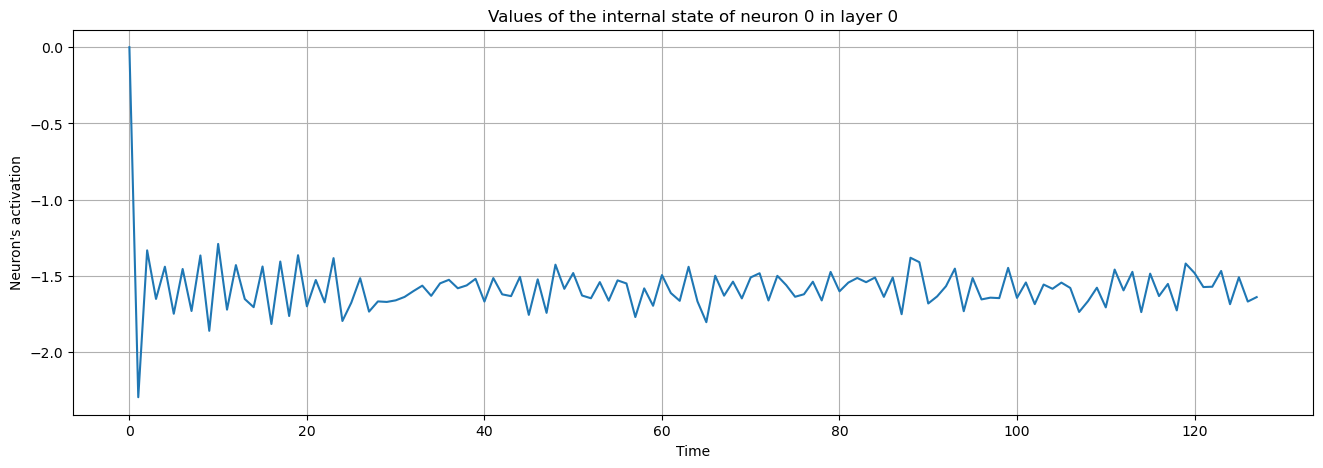

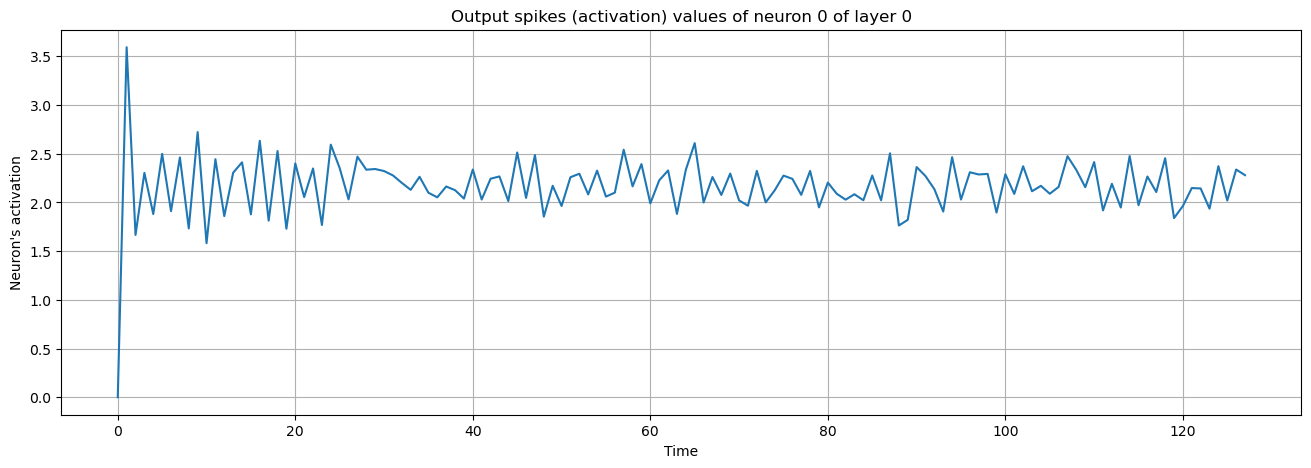

The output neuron of the label:


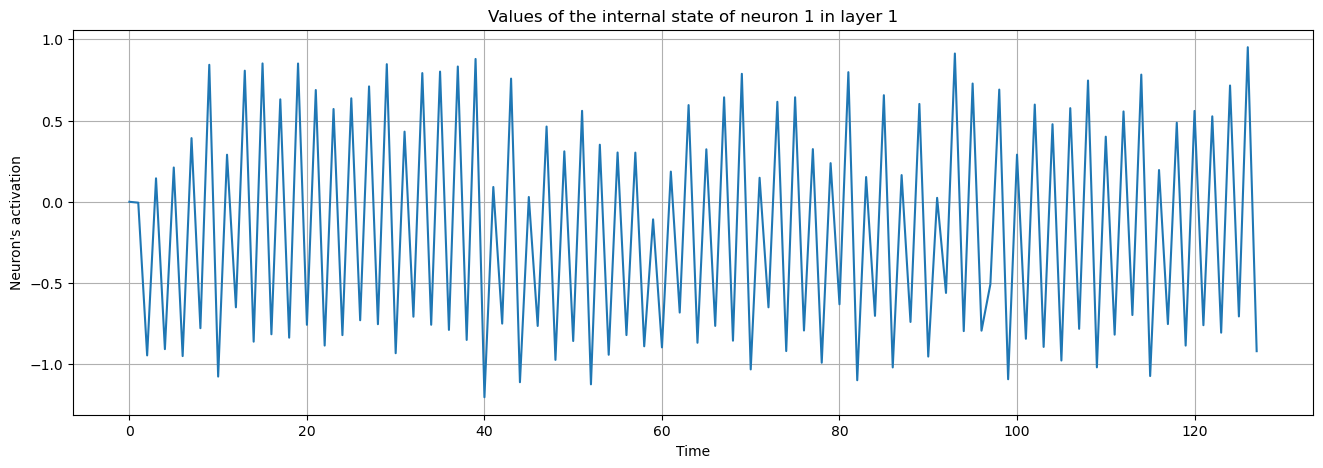

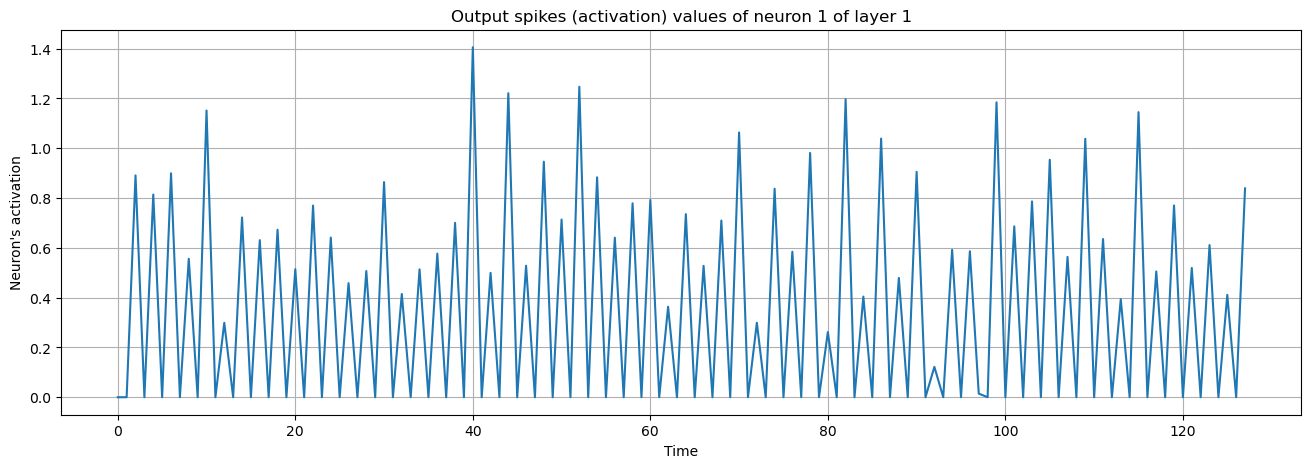

In [94]:
print("A hidden neuron that looks excited:")
spiking_model_3layers.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model_3layers.visualize_neuron(x, layer_idx=1, neuron_idx=y)


Test set: Average loss: 0.6446, Accuracy: 3211/5000 (64.22%)

Accuracy of the model: 64.22%


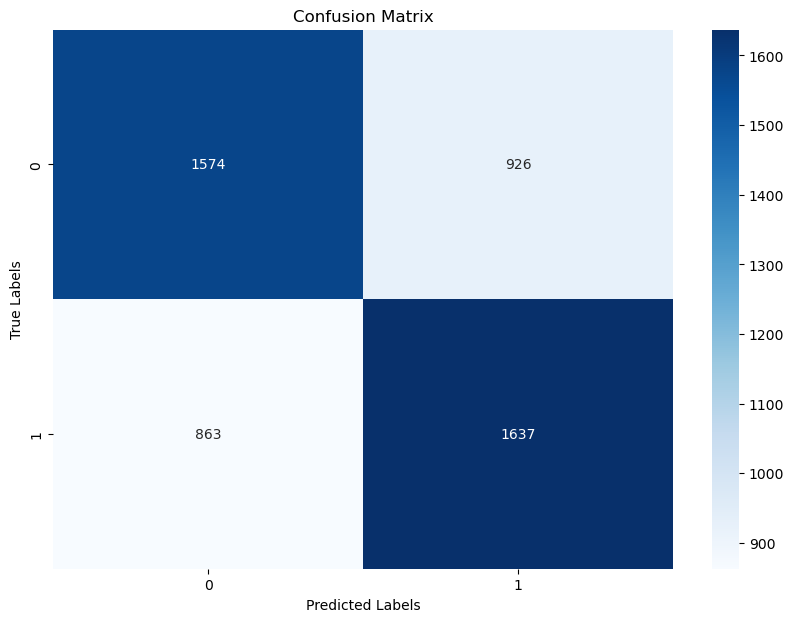

In [97]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Modify or add in your training epochs loop or testing phase
conf_matrix_3layer, accuracy_3layer = test(spiking_model_3layers, device, test_set_loader) 

print("Accuracy of the model: {:.2f}%".format(100. * accuracy_3layer))

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_3layer, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# train more than 3 epocs 

In [62]:
def train_more_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    accuracies = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    
    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    
    epoch = 4
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)


    epoch = 5
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

In [63]:
spiking_model_3layers_more_epochs = Pulse_Network_3layer(device, n_time_steps=128, begin_eval=0)
train_more_epochs(spiking_model_3layers_more_epochs)

Train Epoch: 1 [0/19998 (0%)] Loss: 2.302400 Accuracy: 46.88%
Train Epoch: 1 [1280/19998 (6%)] Loss: 2.276807 Accuracy: 43.75%
Train Epoch: 1 [2560/19998 (13%)] Loss: 2.200811 Accuracy: 57.81%
Train Epoch: 1 [3840/19998 (19%)] Loss: 2.050305 Accuracy: 52.34%
Train Epoch: 1 [5120/19998 (25%)] Loss: 2.048084 Accuracy: 46.09%
Train Epoch: 1 [6400/19998 (32%)] Loss: 1.876620 Accuracy: 47.66%
Train Epoch: 1 [7680/19998 (38%)] Loss: 1.002481 Accuracy: 53.91%
Train Epoch: 1 [8960/19998 (45%)] Loss: 0.932621 Accuracy: 52.34%
Train Epoch: 1 [10240/19998 (51%)] Loss: 0.779349 Accuracy: 61.72%
Train Epoch: 1 [11520/19998 (57%)] Loss: 1.494114 Accuracy: 53.91%
Train Epoch: 1 [12800/19998 (64%)] Loss: 0.820494 Accuracy: 57.81%
Train Epoch: 1 [14080/19998 (70%)] Loss: 0.752866 Accuracy: 56.25%


/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [15360/19998 (76%)] Loss: 0.773751 Accuracy: 54.69%
Train Epoch: 1 [16640/19998 (83%)] Loss: 0.772731 Accuracy: 56.25%
Train Epoch: 1 [17920/19998 (89%)] Loss: 0.695835 Accuracy: 59.38%
Train Epoch: 1 [19200/19998 (96%)] Loss: 0.717518 Accuracy: 56.25%

Test set: Average loss: 0.7554, Accuracy: 2837/5000 (56.74%)

Train Epoch: 2 [0/19998 (0%)] Loss: 0.696957 Accuracy: 56.25%
Train Epoch: 2 [1280/19998 (6%)] Loss: 0.674363 Accuracy: 62.50%
Train Epoch: 2 [2560/19998 (13%)] Loss: 0.750667 Accuracy: 54.69%
Train Epoch: 2 [3840/19998 (19%)] Loss: 0.654959 Accuracy: 63.28%
Train Epoch: 2 [5120/19998 (25%)] Loss: 0.696083 Accuracy: 60.94%
Train Epoch: 2 [6400/19998 (32%)] Loss: 0.640447 Accuracy: 64.84%
Train Epoch: 2 [7680/19998 (38%)] Loss: 0.655757 Accuracy: 65.62%
Train Epoch: 2 [8960/19998 (45%)] Loss: 0.630575 Accuracy: 65.62%
Train Epoch: 2 [10240/19998 (51%)] Loss: 0.696093 Accuracy: 60.94%
Train Epoch: 2 [11520/19998 (57%)] Loss: 0.649917 Accuracy: 64.06%
Train Epoch:

/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 2 [17920/19998 (89%)] Loss: 0.623339 Accuracy: 64.84%
Train Epoch: 2 [19200/19998 (96%)] Loss: 0.706177 Accuracy: 56.25%

Test set: Average loss: 0.6673, Accuracy: 3064/5000 (61.28%)

Train Epoch: 3 [0/19998 (0%)] Loss: 0.698125 Accuracy: 58.59%
Train Epoch: 3 [1280/19998 (6%)] Loss: 0.679208 Accuracy: 60.94%
Train Epoch: 3 [2560/19998 (13%)] Loss: 0.629327 Accuracy: 69.53%
Train Epoch: 3 [3840/19998 (19%)] Loss: 0.683575 Accuracy: 55.47%
Train Epoch: 3 [5120/19998 (25%)] Loss: 0.612095 Accuracy: 70.31%
Train Epoch: 3 [6400/19998 (32%)] Loss: 0.643913 Accuracy: 66.41%
Train Epoch: 3 [7680/19998 (38%)] Loss: 0.672488 Accuracy: 60.94%
Train Epoch: 3 [8960/19998 (45%)] Loss: 0.674119 Accuracy: 57.03%
Train Epoch: 3 [10240/19998 (51%)] Loss: 0.647092 Accuracy: 61.72%
Train Epoch: 3 [11520/19998 (57%)] Loss: 0.695531 Accuracy: 57.81%
Train Epoch: 3 [12800/19998 (64%)] Loss: 0.658905 Accuracy: 59.38%
Train Epoch: 3 [14080/19998 (70%)] Loss: 0.648822 Accuracy: 64.84%
Train Epoch:

/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Test set: Average loss: 0.6521, Accuracy: 3120/5000 (62.40%)

Train Epoch: 4 [0/19998 (0%)] Loss: 0.646315 Accuracy: 61.72%
Train Epoch: 4 [1280/19998 (6%)] Loss: 0.661431 Accuracy: 68.75%
Train Epoch: 4 [2560/19998 (13%)] Loss: 0.647495 Accuracy: 65.62%
Train Epoch: 4 [3840/19998 (19%)] Loss: 0.613237 Accuracy: 67.97%
Train Epoch: 4 [5120/19998 (25%)] Loss: 0.622876 Accuracy: 64.06%
Train Epoch: 4 [6400/19998 (32%)] Loss: 0.694524 Accuracy: 55.47%
Train Epoch: 4 [7680/19998 (38%)] Loss: 0.666555 Accuracy: 63.28%
Train Epoch: 4 [8960/19998 (45%)] Loss: 0.672565 Accuracy: 58.59%
Train Epoch: 4 [10240/19998 (51%)] Loss: 0.716898 Accuracy: 54.69%
Train Epoch: 4 [11520/19998 (57%)] Loss: 0.683768 Accuracy: 60.16%
Train Epoch: 4 [12800/19998 (64%)] Loss: 0.638734 Accuracy: 64.84%
Train Epoch: 4 [14080/19998 (70%)] Loss: 0.662822 Accuracy: 57.81%
Train Epoch: 4 [15360/19998 (76%)] Loss: 0.595009 Accuracy: 65.62%


/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 4 [16640/19998 (83%)] Loss: 0.612316 Accuracy: 67.97%
Train Epoch: 4 [17920/19998 (89%)] Loss: 0.632868 Accuracy: 64.84%
Train Epoch: 4 [19200/19998 (96%)] Loss: 0.626033 Accuracy: 66.41%

Test set: Average loss: 0.7868, Accuracy: 2740/5000 (54.80%)

Train Epoch: 5 [0/19998 (0%)] Loss: 0.734165 Accuracy: 55.47%
Train Epoch: 5 [1280/19998 (6%)] Loss: 0.618032 Accuracy: 64.84%
Train Epoch: 5 [2560/19998 (13%)] Loss: 0.651921 Accuracy: 64.06%
Train Epoch: 5 [3840/19998 (19%)] Loss: 0.605212 Accuracy: 67.19%
Train Epoch: 5 [5120/19998 (25%)] Loss: 0.599726 Accuracy: 65.62%
Train Epoch: 5 [6400/19998 (32%)] Loss: 0.615374 Accuracy: 62.50%
Train Epoch: 5 [7680/19998 (38%)] Loss: 0.633946 Accuracy: 65.62%
Train Epoch: 5 [8960/19998 (45%)] Loss: 0.612848 Accuracy: 60.16%
Train Epoch: 5 [10240/19998 (51%)] Loss: 0.575939 Accuracy: 72.66%
Train Epoch: 5 [11520/19998 (57%)] Loss: 0.644060 Accuracy: 60.94%
Train Epoch: 5 [12800/19998 (64%)] Loss: 0.619953 Accuracy: 70.31%
Train Epoch:

/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 5 [19200/19998 (96%)] Loss: 0.597365 Accuracy: 67.97%

Test set: Average loss: 0.6401, Accuracy: 3178/5000 (63.56%)




Test set: Average loss: 0.6405, Accuracy: 3186/5000 (63.72%)

Accuracy of the model: 63.72%


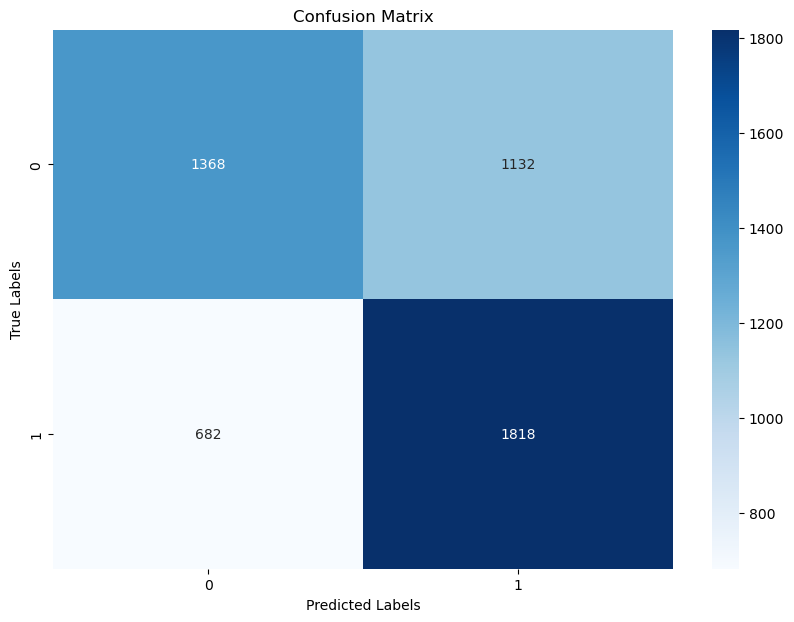

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Modify or add in your training epochs loop or testing phase
conf_matrix_3layer_more_epochs, accuracy_3layer_more_epochs = test(spiking_model_3layers_more_epochs, device, test_set_loader) 

print("Accuracy of the model: {:.2f}%".format(100. * accuracy_3layer_more_epochs))

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_3layer_more_epochs, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Binary Classification Using 4 Layer SNN model

In [417]:

class Pulse_Network_4layer(nn.Module):
    def __init__(self, computation_device, n_time_steps, begin_eval):
        super(Pulse_Network_4layer, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.computation_device = computation_device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(computation_device)
        
        self.layer1 = RNN_Spiking_Neuron(
            computation_device, n_inputs=64*64*3, n_hidden=100, 
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            computation_device, n_inputs=100, n_hidden=50,  
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.layer3 = RNN_Spiking_Neuron(
            computation_device, n_inputs=50, n_hidden=30,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.layer4 = RNN_Spiking_Neuron(  
            computation_device, n_inputs=30, n_hidden=10, 
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False)
        
        self.to(self.computation_device)
    
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state()
        self.layer4.reset_state()  

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = []
        all_layer3_outputs = []
        all_layer4_states = []  
        all_layer4_outputs = []  
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # Processing through layers
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output)
            layer4_state, layer4_output = self.layer4(layer3_output)  
            
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state)
            all_layer3_outputs.append(layer3_output)
            all_layer4_states.append(layer4_state)  
            all_layer4_outputs.append(layer4_output) 
            out.append(layer4_output) 
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs], [all_layer3_states, all_layer3_outputs], [all_layer4_states, all_layer4_outputs]]  # Include layer 4 in return
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)



  
    def Display_neurons(self, x, width=None, height=None):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network_4layer.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
        
            self.plot_layer(layer_state, title=f"Inner state values of neurons for layer {i+1}")
            self.plot_layer(layer_output, title=f"Output spikes (activation) values of neurons for layer {i+1}")

    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]

        layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title=f"Inner state values of neuron {neuron_idx} of layer {layer_idx+1}")
        self.plot_neuron(layer_output[neuron_idx], title=f"Output spikes (activation) values of neuron {neuron_idx} of layer {layer_idx+1}")

    def plot_layer(self, layer_values, title, width=None, height=None):
        if width is None:
            width = max(5, layer_values.shape[0] / 8)
        if height is None:
            height = max(5, layer_values.shape[1] / 8)

        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(5, len(neuron_through_time) / 8)
        height = 5
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.grid(True)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()


Train Epoch: 1 [0/19998 (0%)] Loss: 2.302240 Accuracy: 50.00%
Train Epoch: 1 [1280/19998 (6%)] Loss: 2.260455 Accuracy: 45.31%
Train Epoch: 1 [2560/19998 (13%)] Loss: 2.138933 Accuracy: 49.22%
Train Epoch: 1 [3840/19998 (19%)] Loss: 1.880279 Accuracy: 57.03%
Train Epoch: 1 [5120/19998 (25%)] Loss: 1.966596 Accuracy: 48.44%
Train Epoch: 1 [6400/19998 (32%)] Loss: 1.711374 Accuracy: 57.03%
Train Epoch: 1 [7680/19998 (38%)] Loss: 1.463171 Accuracy: 53.12%
Train Epoch: 1 [8960/19998 (45%)] Loss: 1.148912 Accuracy: 50.00%


/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [10240/19998 (51%)] Loss: 0.903288 Accuracy: 48.44%
Train Epoch: 1 [11520/19998 (57%)] Loss: 0.816010 Accuracy: 46.88%
Train Epoch: 1 [12800/19998 (64%)] Loss: 0.794003 Accuracy: 51.56%
Train Epoch: 1 [14080/19998 (70%)] Loss: 0.756270 Accuracy: 50.00%
Train Epoch: 1 [15360/19998 (76%)] Loss: 0.735923 Accuracy: 50.78%
Train Epoch: 1 [16640/19998 (83%)] Loss: 0.718224 Accuracy: 53.91%
Train Epoch: 1 [17920/19998 (89%)] Loss: 0.710781 Accuracy: 53.91%
Train Epoch: 1 [19200/19998 (96%)] Loss: 0.810114 Accuracy: 45.31%

Test set: Average loss: 0.7037, Accuracy: 2756/5000 (55.12%)

Train Epoch: 2 [0/19998 (0%)] Loss: 0.703775 Accuracy: 54.69%


/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 2 [1280/19998 (6%)] Loss: 0.695419 Accuracy: 60.16%
Train Epoch: 2 [2560/19998 (13%)] Loss: 0.693011 Accuracy: 59.38%
Train Epoch: 2 [3840/19998 (19%)] Loss: 0.704374 Accuracy: 50.78%
Train Epoch: 2 [5120/19998 (25%)] Loss: 0.699536 Accuracy: 55.47%
Train Epoch: 2 [6400/19998 (32%)] Loss: 0.698474 Accuracy: 53.12%
Train Epoch: 2 [7680/19998 (38%)] Loss: 0.692785 Accuracy: 54.69%
Train Epoch: 2 [8960/19998 (45%)] Loss: 0.673121 Accuracy: 61.72%
Train Epoch: 2 [10240/19998 (51%)] Loss: 0.678038 Accuracy: 55.47%
Train Epoch: 2 [11520/19998 (57%)] Loss: 0.677362 Accuracy: 62.50%
Train Epoch: 2 [12800/19998 (64%)] Loss: 0.689951 Accuracy: 58.59%
Train Epoch: 2 [14080/19998 (70%)] Loss: 0.696219 Accuracy: 52.34%
Train Epoch: 2 [15360/19998 (76%)] Loss: 0.703568 Accuracy: 53.91%
Train Epoch: 2 [16640/19998 (83%)] Loss: 0.670763 Accuracy: 57.03%
Train Epoch: 2 [17920/19998 (89%)] Loss: 0.665252 Accuracy: 61.72%
Train Epoch: 2 [19200/19998 (96%)] Loss: 0.689678 Accuracy: 60.16%

Te

/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 3 [1280/19998 (6%)] Loss: 0.687720 Accuracy: 60.16%
Train Epoch: 3 [2560/19998 (13%)] Loss: 0.682250 Accuracy: 61.72%
Train Epoch: 3 [3840/19998 (19%)] Loss: 0.668382 Accuracy: 60.16%
Train Epoch: 3 [5120/19998 (25%)] Loss: 0.698338 Accuracy: 57.81%
Train Epoch: 3 [6400/19998 (32%)] Loss: 0.647387 Accuracy: 67.19%
Train Epoch: 3 [7680/19998 (38%)] Loss: 0.687796 Accuracy: 58.59%
Train Epoch: 3 [8960/19998 (45%)] Loss: 0.695632 Accuracy: 51.56%
Train Epoch: 3 [10240/19998 (51%)] Loss: 0.646228 Accuracy: 68.75%
Train Epoch: 3 [11520/19998 (57%)] Loss: 0.657367 Accuracy: 64.06%
Train Epoch: 3 [12800/19998 (64%)] Loss: 0.637815 Accuracy: 66.41%
Train Epoch: 3 [14080/19998 (70%)] Loss: 0.675582 Accuracy: 62.50%
Train Epoch: 3 [15360/19998 (76%)] Loss: 0.680301 Accuracy: 57.81%
Train Epoch: 3 [16640/19998 (83%)] Loss: 0.696882 Accuracy: 55.47%
Train Epoch: 3 [17920/19998 (89%)] Loss: 0.658800 Accuracy: 65.62%
Train Epoch: 3 [19200/19998 (96%)] Loss: 0.650036 Accuracy: 60.94%

Te

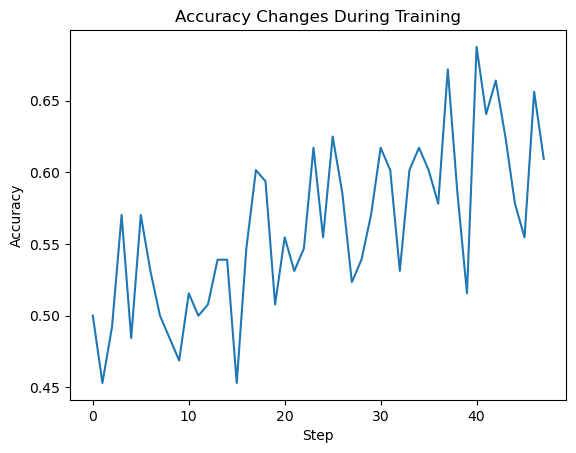

In [109]:
spiking_model_4layers = Pulse_Network_4layer(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_4layers)

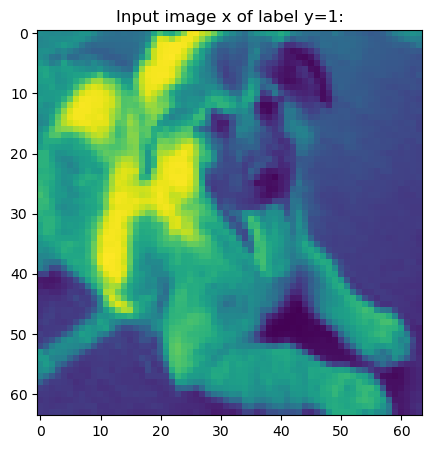

In [110]:
data, target = test_set_loader.__iter__().__next__()

x = torch.stack([data[2]]) 
y = target.data.numpy()[2]
plt.figure(figsize=(5,5))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()


A hidden neuron that looks excited:


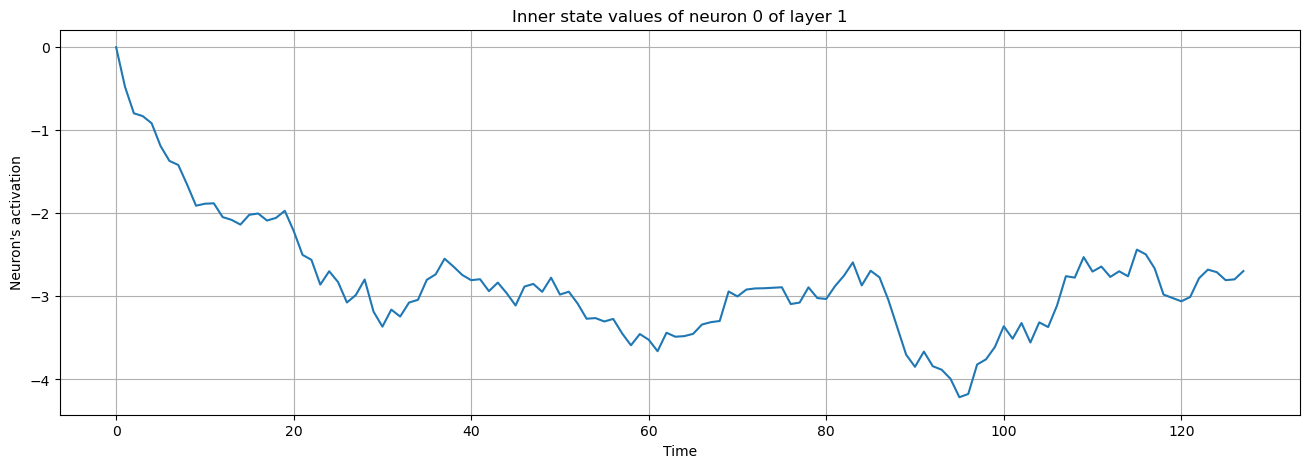

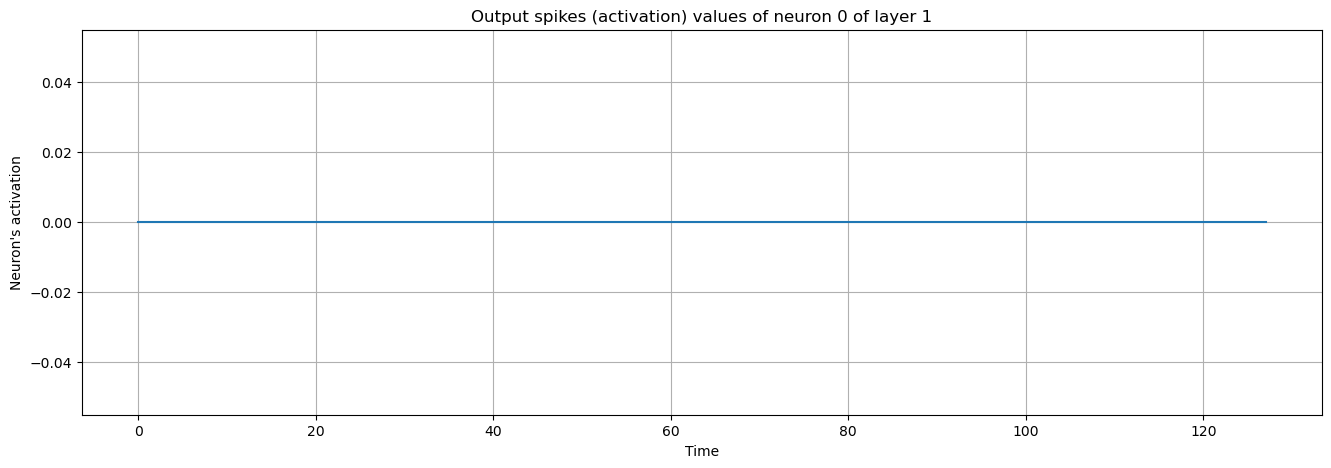

The output neuron of the label (third layer), for label y=1:


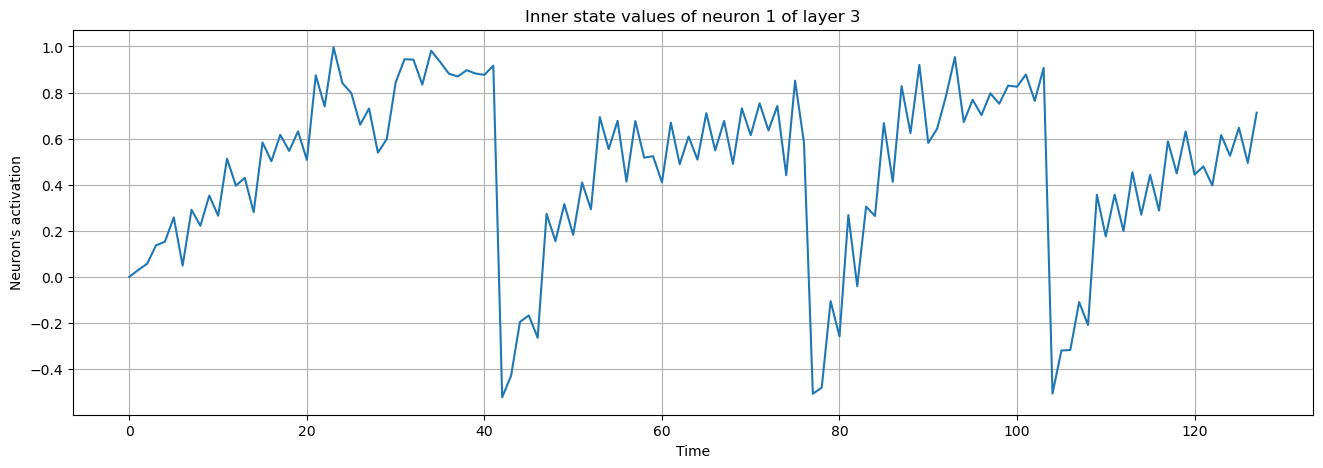

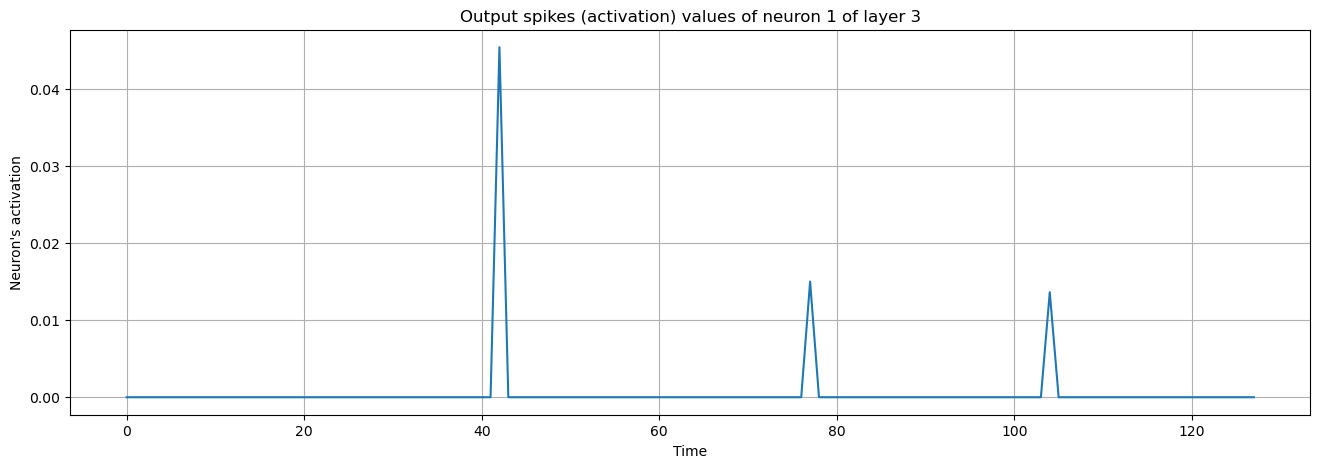

In [115]:
print("A hidden neuron that looks excited:")
spiking_model_4layers.visualize_neuron(x, layer_idx=0, neuron_idx=0)

print(f"The output neuron of the label (third layer), for label y={y}:")
spiking_model_4layers.visualize_neuron(x, layer_idx=2, neuron_idx=y)


Test set: Average loss: 0.6662, Accuracy: 3060/5000 (61.20%)

Accuracy of the model: 64.22%


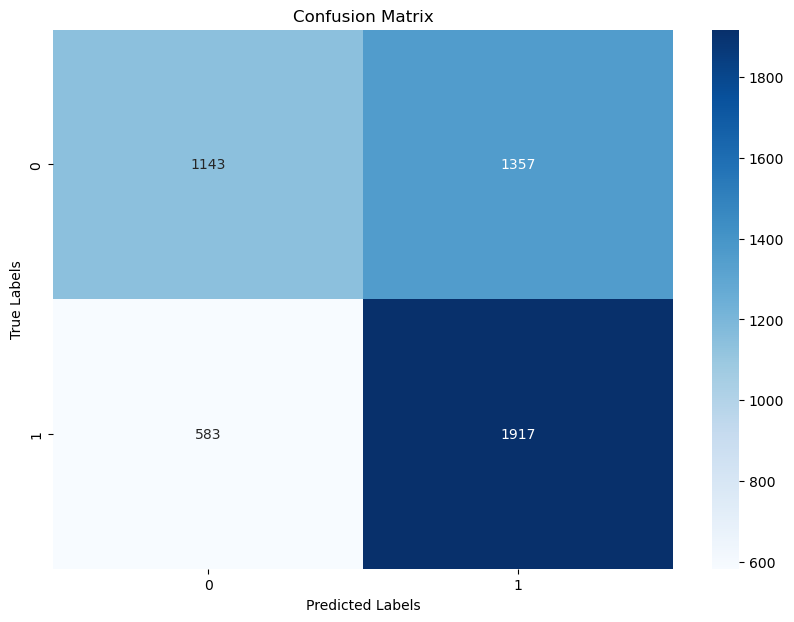

In [112]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Modify or add in your training epochs loop or testing phase
conf_matrix_4layer, accuracy_4layer = test(spiking_model_4layers, device, test_set_loader) 

print("Accuracy of the model: {:.2f}%".format(100. * accuracy_3layer))

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_4layer, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


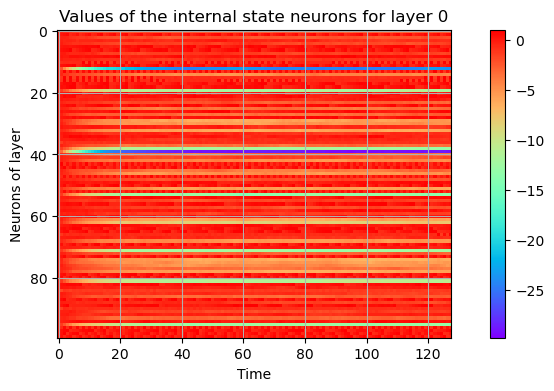

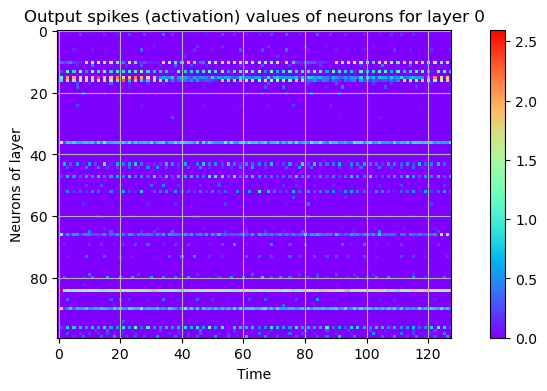

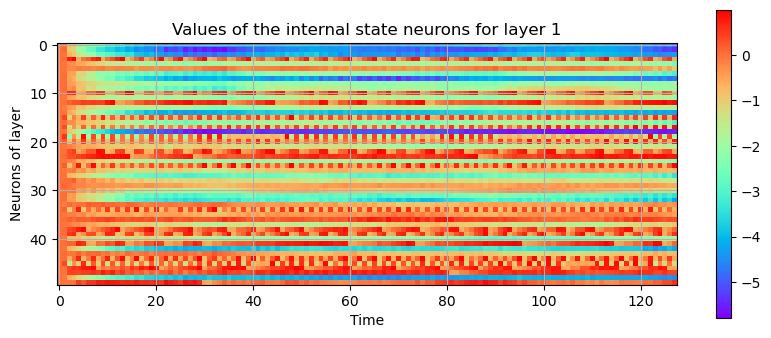

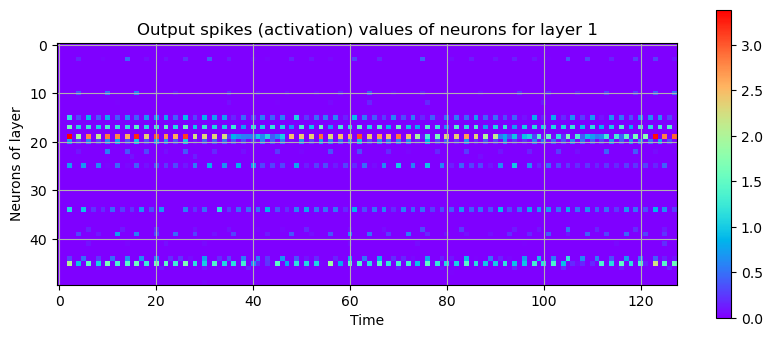

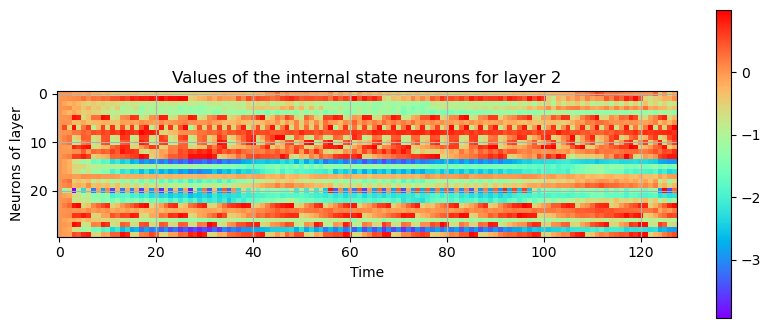

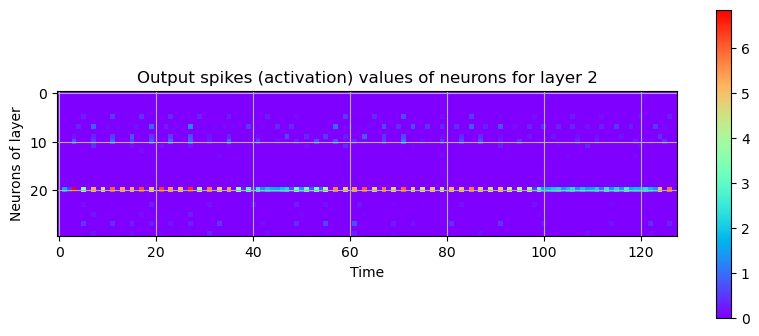

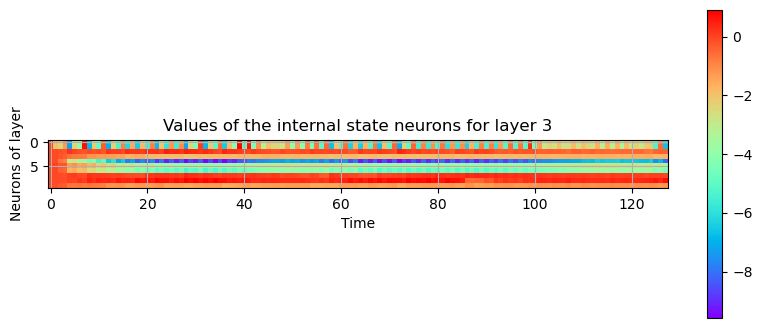

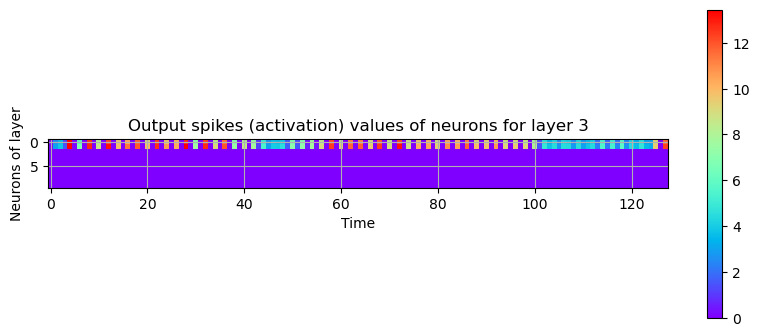

In [120]:
spiking_model_4layers.Display_neurons(x, width=10, height=4)

# Comparison between 2,3 and 4 layer SNN models for binary classifications using large dataset 

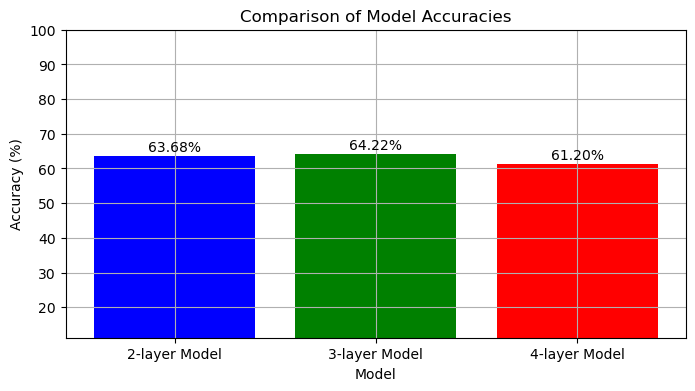

In [407]:
import matplotlib.pyplot as plt


accuracy_scores = {
    '2-layer Model': accuracy_2layer,
    '3-layer Model': accuracy_3layer,
    '4-layer Model': accuracy_4layer
}

# Set up the matplotlib figure
plt.figure(figsize=(8, 4))

# Create a bar chart
models = list(accuracy_scores.keys())
accuracies = [100 * accuracy_scores[model] for model in models]  # Convert to percentages
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.grid(True)
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim([min(accuracies) - 50, 100])  

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

plt.show()


# Multi class Classification using SNN

In [297]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Define transformation
transform = Compose([
    Resize((64, 64)), 
    ToTensor(),     
    Normalize(mean=[0.5], std=[0.5]) 
])


dataset_path = './S_data' 
dataset = ImageFolder(root=dataset_path, transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_set_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_set_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Data:


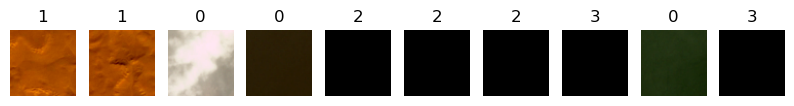

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing Data:


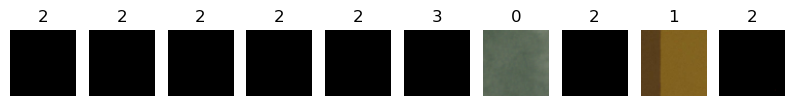

In [300]:
import matplotlib.pyplot as plt

def show_images(dataloader):

    for images, labels in dataloader:
        plt.figure(figsize=(10, 10)) 
        for i in range(10, 20):
            plt.subplot(1, 10, i - 9)
            plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            plt.title(labels[i].item()) 
            plt.axis('off') 
        plt.show()
        break
print("Training Data:")
show_images(train_set_loader)
print("Testing Data:")
show_images(test_set_loader)


In [327]:
import matplotlib.pyplot as plt

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    model.train()
    accuracies = []  # Store accuracy values
    
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            accuracies.append(correct)  # Store accuracy
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
    
    return accuracies

In [302]:


def train_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    accuracies = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    
    plot_accuracies(accuracies)

In [303]:
def plot_accuracies(accuracies):
    plt.plot(accuracies)
    plt.title('Accuracy Changes During Training')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.show()

In [304]:
def test(model, device, test_set_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")


In [326]:

    
class RNN_Spiking_Neuron(nn.Module):
    
    def __init__(self, device, n_inputs=64*64, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(RNN_Spiking_Neuron, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):

        if self.prev_inner.dim() == 1:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        input_excitation = self.fc(x)
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        outer_excitation = F.relu(inner_excitation - self.threshold)
        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        outer_excitation = outer_excitation
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output

In [415]:

class Input_layer(nn.Module):
    
    def __init__(self, device):
        super(Input_layer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1) 
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x

In [305]:
class Output_layer(nn.Module):
    
    def __init__(self, average_output=True):

        super(Output_layer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)

# Multi Class Classification Using 2 Layer SNN model

In [416]:

class Pulse_Network_2layer_multilayer(nn.Module):
    def __init__(self, device, n_time_steps, begin_eval):
        super(Pulse_Network_2layer_multilayer, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(device)
        
        self.layer1 = RNN_Spiking_Neuron(
            device, n_inputs=64*64*3, n_hidden=100,  # Adjust for your input dimension
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)

 
    
    def forward_through_time(self, x):

        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def Display_neurons(self, x, width=None, height=None):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

            self.plot_layer(layer_state, title="Values of the internal state neurons for layer {}".format(i), width=width, height=height)
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i), width=width, height=height)
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Values of the internal state of neuron {} in layer {}.".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Activation values (spikes) of neuron {} in layer {}.".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title, width=None, height=None):
        if width is None:
            width = max(5, layer_values.shape[0] / 8)
        if height is None:
            height = max(5, layer_values.shape[1] / 8)

        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(5, len(neuron_through_time) / 8)
        height = 5
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.grid(True)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()


Train Epoch: 1 [0/4504 (0%)] Loss: 2.284549 Accuracy: 22.66%
Train Epoch: 1 [1280/4504 (28%)] Loss: 287.548828 Accuracy: 0.00%
Train Epoch: 1 [2560/4504 (56%)] Loss: 3753940.250000 Accuracy: 19.53%
Train Epoch: 1 [3840/4504 (83%)] Loss: 24072568832.000000 Accuracy: 0.78%


/Users/kaushikdas/anaconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1164979362.6406, Accuracy: 4/1127 (0.35%)

Train Epoch: 2 [0/4504 (0%)] Loss: 158555766784.000000 Accuracy: 0.00%
Train Epoch: 2 [1280/4504 (28%)] Loss: 26725236867072.000000 Accuracy: 0.00%
Train Epoch: 2 [2560/4504 (56%)] Loss: 851240484864.000000 Accuracy: 29.69%
Train Epoch: 2 [3840/4504 (83%)] Loss: 604555247616.000000 Accuracy: 42.97%

Test set: Average loss: 566287598.9636, Accuracy: 676/1127 (59.98%)

Train Epoch: 3 [0/4504 (0%)] Loss: 40201818112.000000 Accuracy: 60.16%
Train Epoch: 3 [1280/4504 (28%)] Loss: 106516037632.000000 Accuracy: 76.56%
Train Epoch: 3 [2560/4504 (56%)] Loss: 59408781312.000000 Accuracy: 64.84%
Train Epoch: 3 [3840/4504 (83%)] Loss: 14267576320.000000 Accuracy: 71.09%

Test set: Average loss: 191192033.1074, Accuracy: 694/1127 (61.58%)



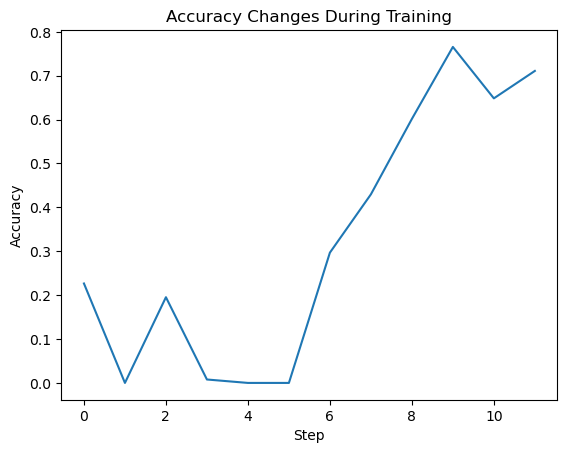

In [291]:
spiking_model_2layer_multiclass = Pulse_Network_2layer(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_2layer_multiclass)

A hidden neuron that looks excited:


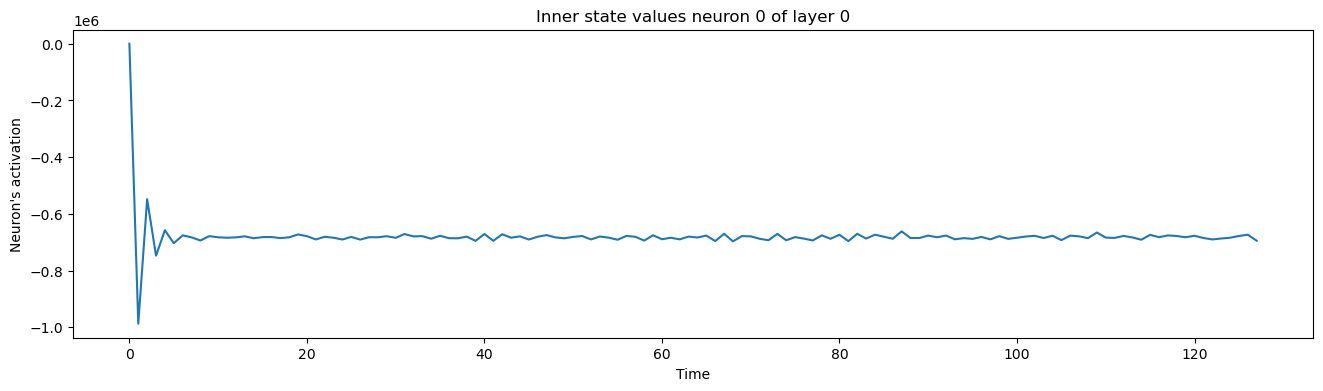

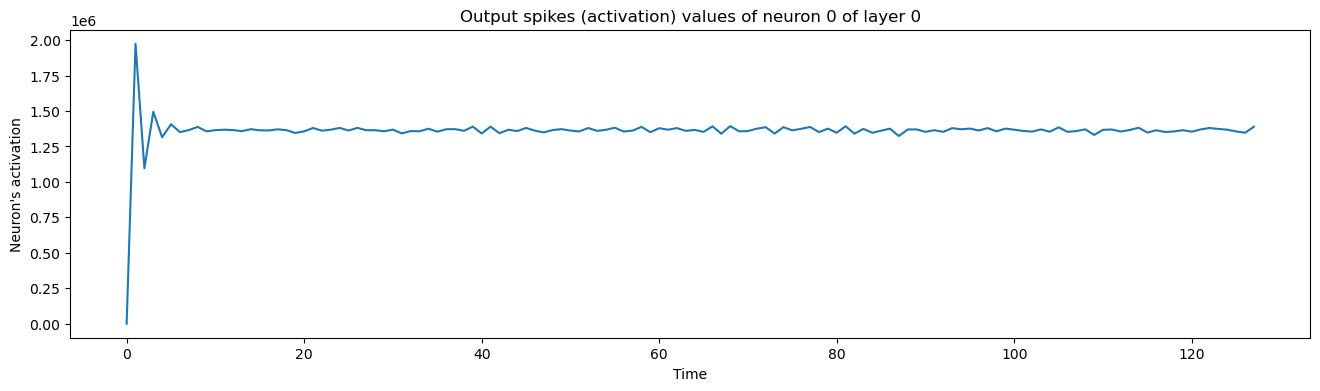

The output neuron of the label:


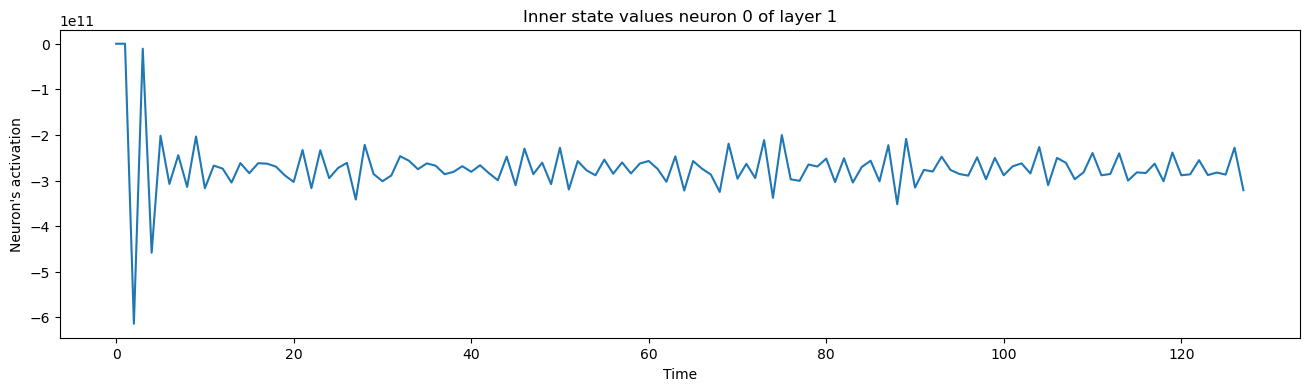

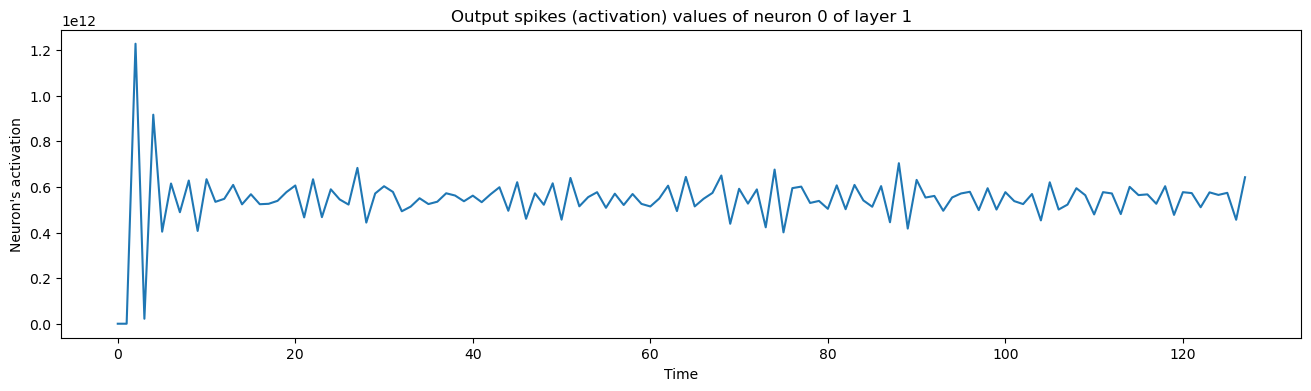

In [308]:
print("A hidden neuron that looks excited:")
spiking_model_2layer_multiclass.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model_2layer_multiclass.visualize_neuron(x, layer_idx=1, neuron_idx=y)

In [324]:
def test(model, device, test_set_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Save predictions and targets for confusion matrix
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_set_loader.dataset)
    
    # Calculate confusion matrix and accuracy
    conf_matrix = confusion_matrix(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)

    # Print test results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    
    return conf_matrix, accuracy



Test set: Average loss: 24425231611.6841, Accuracy: 693/1127 (61.49%)

Accuracy of the model: 61.49%


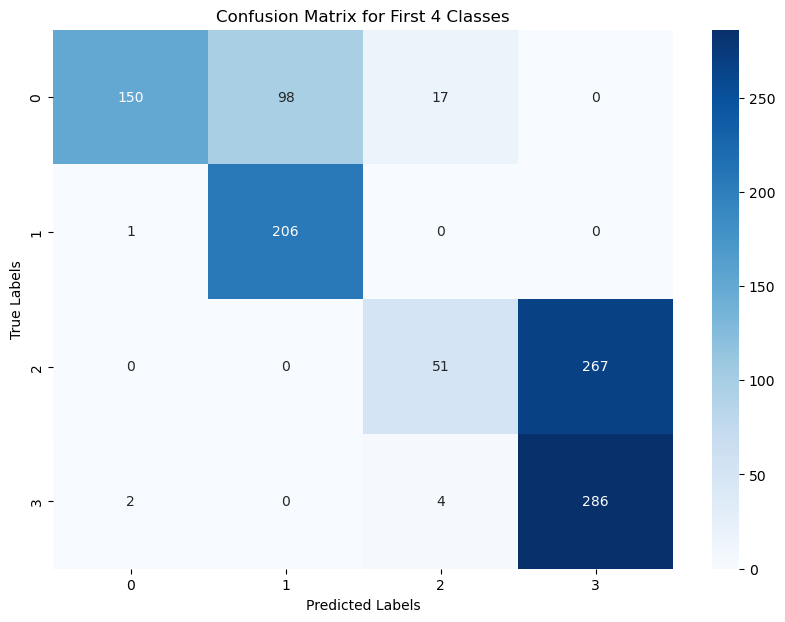

In [296]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix_2layer_multiclass, accuracy_2layer_multiclass = test(spiking_model_2layer_multiclass, device, test_set_loader)
conf_matrix_2layer_multiclass_reduced = conf_matrix_2layer_multiclass[:4, :4]
print("Accuracy of the model: {:.2f}%".format(100. * accuracy_2layer_multiclass))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_2layer_multiclass_reduced, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for First 4 Classes')
plt.show()


# Multi Class Classification Using 3 Layer SNN model

In [265]:
class RNN_Spiking_Neuron(nn.Module):
    
    def __init__(self, device, n_inputs=64*64, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(RNN_Spiking_Neuron, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):

        if self.prev_inner.dim() == 1:
        
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        input_excitation = self.fc(x)
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        outer_excitation = F.relu(inner_excitation - self.threshold)
        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        outer_excitation = outer_excitation
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output

In [266]:
class Input_layer(nn.Module):
    
    def __init__(self, device):
        super(Input_layer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1) 
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x

In [267]:
class Output_layer(nn.Module):
    
    def __init__(self, average_output=True):

        super(Output_layer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)

In [268]:
class Pulse_Network_3layer_multiclass(nn.Module):
    def __init__(self, device, n_time_steps, begin_eval):
        super(Pulse_Network_3layer_multiclass, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(device)
        
        self.layer1 = RNN_Spiking_Neuron(
            device, n_inputs=64*64*3, n_hidden=100,  # Adjust for your input dimension
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            device, n_inputs=100, n_hidden=50,  # Adjust hidden units as needed
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        # New Layer 3 added here
        self.layer3 = RNN_Spiking_Neuron(
            device, n_inputs=50, n_hidden=10,  # Adjust inputs/outputs as needed
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state()  # Reset state for layer3

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = []  # New list for layer3 states
        all_layer3_outputs = []  # New list for layer3 outputs
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output) 
 
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state)  
            all_layer3_outputs.append(layer3_output) 
            out.append(layer3_state) 
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs], [all_layer3_states, all_layer3_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

 
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state()

        out = []

        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = [] 
        all_layer3_outputs = []  
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # Process through each layer
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output)  
            
            # Append states and outputs for each layer
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state)  
            all_layer3_outputs.append(layer3_output) 
            out.append(layer3_output)  
            
        out = self.output_conversion(torch.stack(out[self.begin_eval:]))
        return out, [[all_layer1_states, all_layer1_outputs], 
                     [all_layer2_states, all_layer2_outputs], 
                     [all_layer3_states, all_layer3_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)



    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()


Train Epoch: 1 [0/4504 (0%)] Loss: 2.302607 Accuracy: 5.47%
Train Epoch: 1 [1280/4504 (28%)] Loss: 2.289561 Accuracy: 31.25%
Train Epoch: 1 [2560/4504 (56%)] Loss: 2.068062 Accuracy: 31.25%
Train Epoch: 1 [3840/4504 (83%)] Loss: 2.112113 Accuracy: 42.97%

Test set: Average loss: 2.0903, Accuracy: 538/1127 (47.74%)

Train Epoch: 2 [0/4504 (0%)] Loss: 2.147688 Accuracy: 46.88%
Train Epoch: 2 [1280/4504 (28%)] Loss: 2.118158 Accuracy: 46.88%
Train Epoch: 2 [2560/4504 (56%)] Loss: 1.939519 Accuracy: 42.97%
Train Epoch: 2 [3840/4504 (83%)] Loss: 1.628795 Accuracy: 51.56%

Test set: Average loss: 1.4818, Accuracy: 638/1127 (56.61%)

Train Epoch: 3 [0/4504 (0%)] Loss: 1.356972 Accuracy: 64.84%
Train Epoch: 3 [1280/4504 (28%)] Loss: 1.365038 Accuracy: 60.94%
Train Epoch: 3 [2560/4504 (56%)] Loss: 1.394590 Accuracy: 60.16%
Train Epoch: 3 [3840/4504 (83%)] Loss: 1.423188 Accuracy: 60.16%

Test set: Average loss: 1.4256, Accuracy: 652/1127 (57.85%)



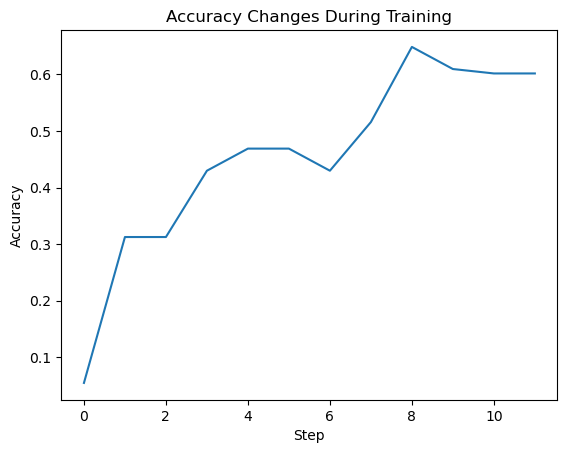

In [269]:
spiking_model_3layer_multiclass = Pulse_Network_3layer_multiclass(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_3layer_multiclass)

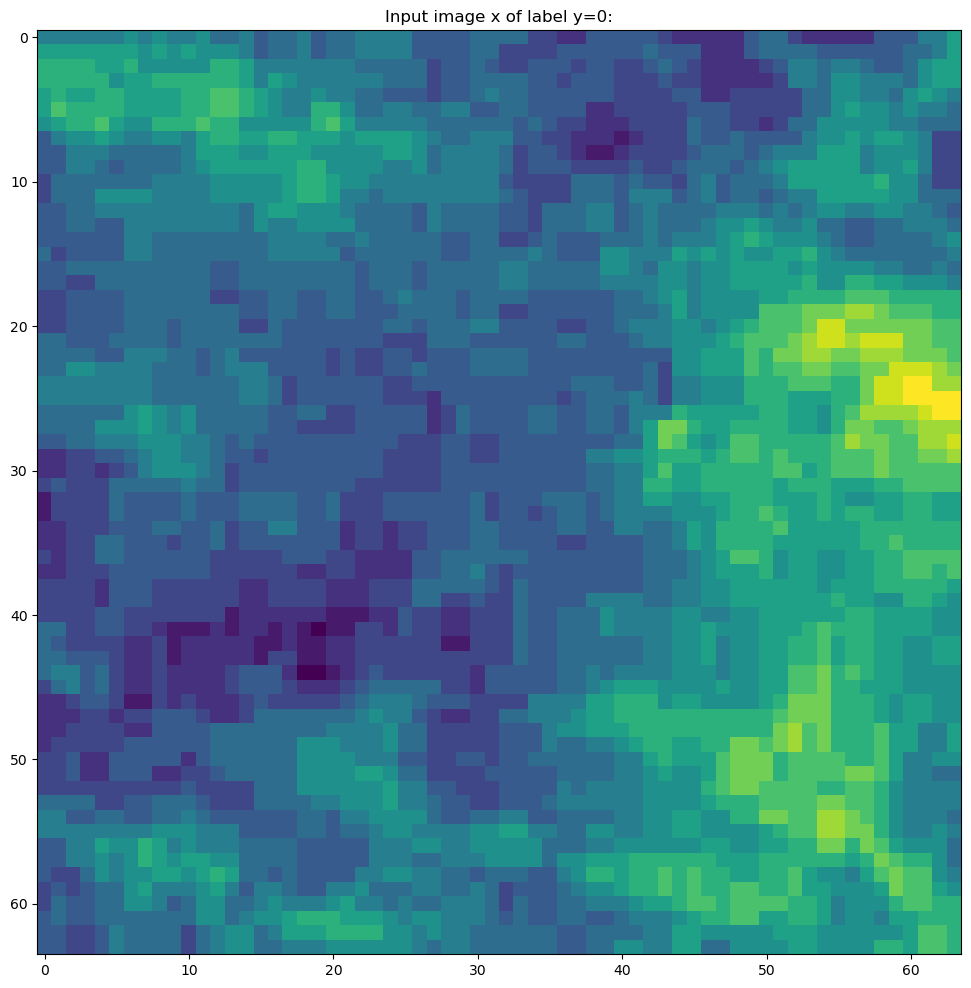

In [270]:
data, target = test_set_loader_multiclass.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[2]]) 
y = target.data.numpy()[2]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()


A hidden neuron that looks excited:


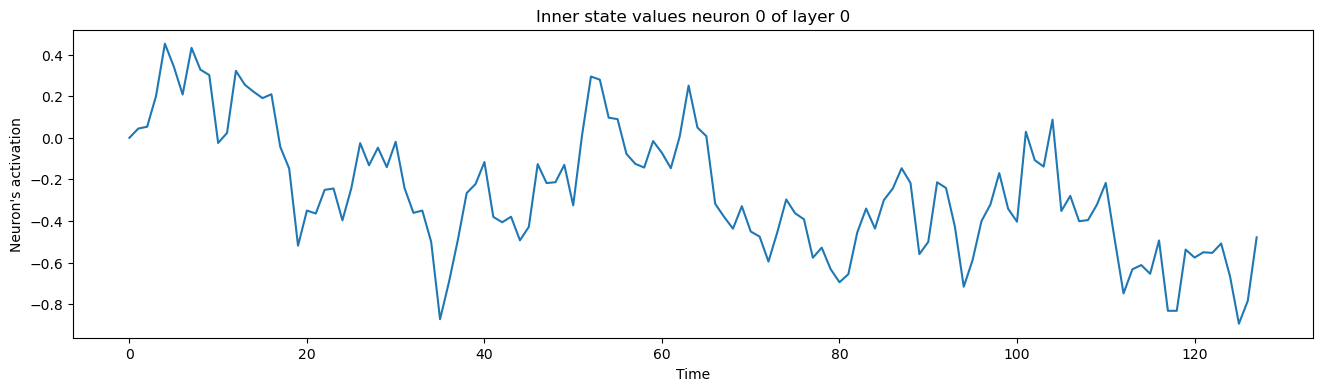

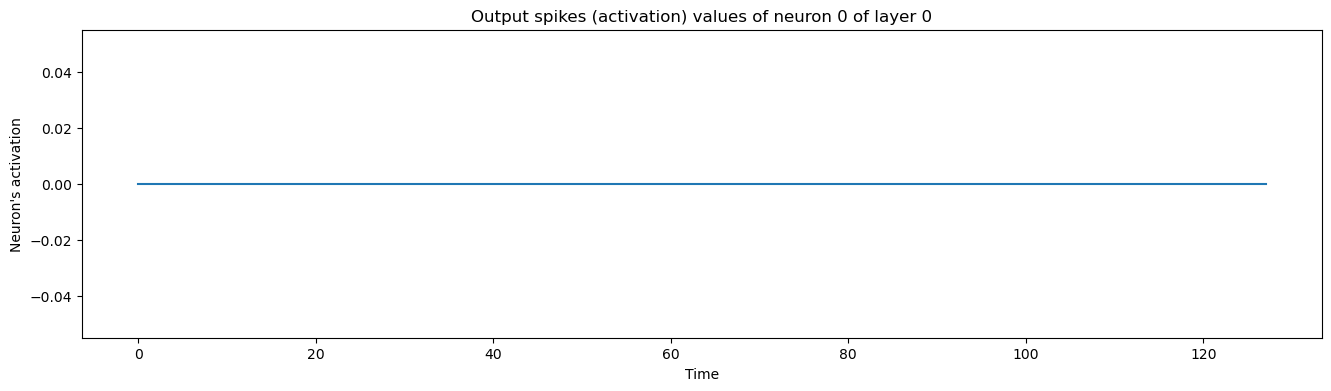

The output neuron of the label:


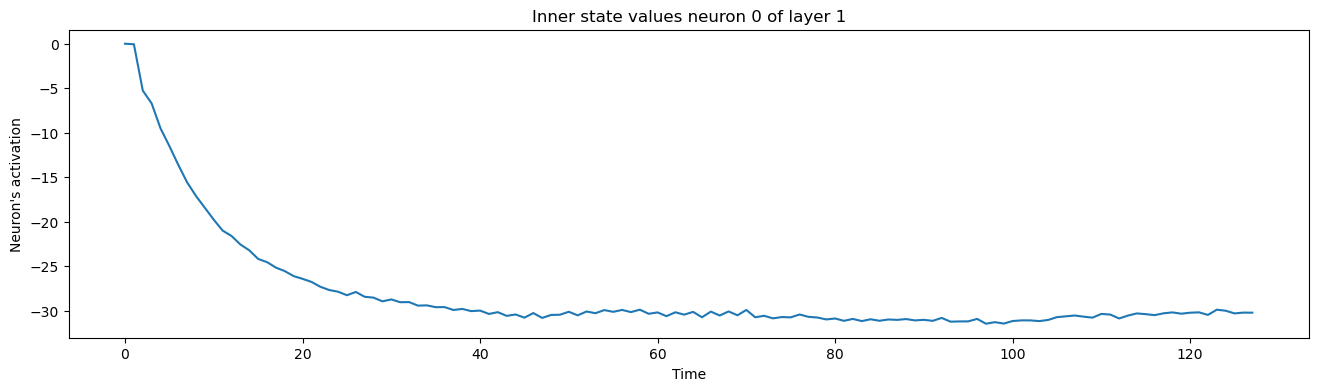

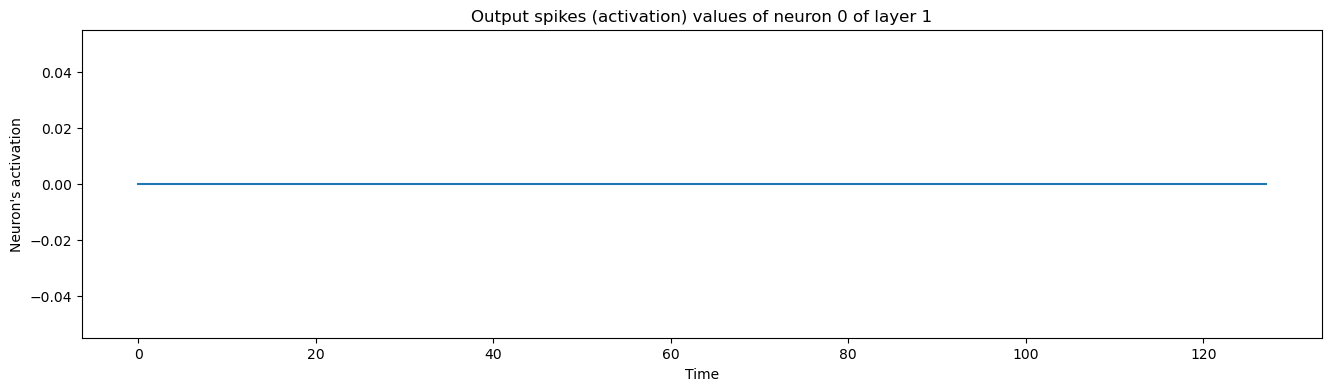

In [271]:
print("A hidden neuron that looks excited:")
spiking_model_3layer_multiclass.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model_3layer_multiclass.visualize_neuron(x, layer_idx=1, neuron_idx=y)


Test set: Average loss: 1.3842, Accuracy: 671/1127 (59.54%)

Accuracy of the model: 59.54%


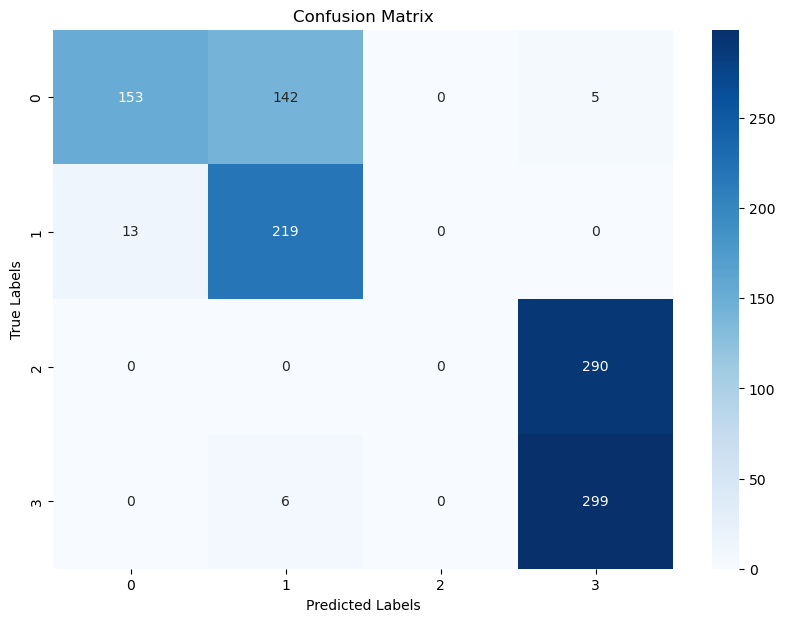

In [272]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


conf_matrix_3layer_multiclass, accuracy_3layer_multiclass = test(spiking_model_3layer_multiclass, device, test_set_loader_multiclass)  

print("Accuracy of the model: {:.2f}%".format(100. * accuracy_3layer_multiclass))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_3layer_multiclass, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Multi Class Classification Using 4 Layer SNN model

In [313]:
class RNN_Spiking_Neuron(nn.Module):
    
    def __init__(self, computation_device, n_inputs=64*64, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(RNN_Spiking_Neuron, self).__init__()
        self.computation_device = computation_device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.computation_device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.computation_device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.computation_device)

    def forward(self, x):

        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])

        input_excitation = self.fc(x)
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        outer_excitation = F.relu(inner_excitation - self.threshold) 
        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        outer_excitation = outer_excitation
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output


In [314]:
class Input_layer(nn.Module):
    
    def __init__(self, computation_device):
        super(Input_layer, self).__init__()
        self.computation_device = computation_device
        
        self.reset_state()
        self.to(self.computation_device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.computation_device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  
        random_activation_perceptron = torch.rand(x.shape).to(self.computation_device)
        return random_activation_perceptron * x

In [315]:
class Output_layer(nn.Module):
    
    def __init__(self, average_output=True):
        super(Output_layer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)

In [319]:

class Pulse_Network_4layer_multiclass(nn.Module):
    def __init__(self, computation_device, n_time_steps, begin_eval):
        super(Pulse_Network_4layer_multiclass, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.computation_device = computation_device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(computation_device)
        
        self.layer1 = RNN_Spiking_Neuron(
            computation_device, n_inputs=64*64*3, n_hidden=100, 
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            computation_device, n_inputs=100, n_hidden=50, 
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.layer3 = RNN_Spiking_Neuron(
            computation_device, n_inputs=50, n_hidden=30,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.layer4 = RNN_Spiking_Neuron(  # New layer 4
            computation_device, n_inputs=30, n_hidden=10,  # Adjust inputs/outputs as needed for layer 4
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False)
        
        self.to(self.computation_device)
    
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state()
        self.layer4.reset_state() 

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = []
        all_layer3_outputs = []
        all_layer4_states = [] 
        all_layer4_outputs = [] 
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output)
            layer4_state, layer4_output = self.layer4(layer3_output) 
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state)
            all_layer3_outputs.append(layer3_output)
            all_layer4_states.append(layer4_state) 
            all_layer4_outputs.append(layer4_output) 
            out.append(layer4_output)  
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs], [all_layer3_states, all_layer3_outputs], [all_layer4_states, all_layer4_outputs]]  # Include layer 4 in return
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)
    
    def Display_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network_4layer.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
        
            self.plot_layer(layer_state, title=f"Inner state values of neurons for layer {i+1}")
            self.plot_layer(layer_output, title=f"Output spikes (activation) values of neurons for layer {i+1}")

   
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network_4layer.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        assert 0 <= layer_idx < len(layers_state), "Layer index out of bounds."

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title=f"Inner state values of neuron {neuron_idx} of layer {layer_idx+1}")
        self.plot_neuron(layer_output[neuron_idx], title=f"Output spikes (activation) values of neuron {neuron_idx} of layer {layer_idx+1}")

    
    
    def plot_layer(self, layer_values, title):
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()



Train Epoch: 1 [0/4504 (0%)] Loss: 2.301867 Accuracy: 21.88%
Train Epoch: 1 [1280/4504 (28%)] Loss: 2.299582 Accuracy: 12.50%
Train Epoch: 1 [2560/4504 (56%)] Loss: 2.270464 Accuracy: 46.09%
Train Epoch: 1 [3840/4504 (83%)] Loss: 2.232756 Accuracy: 19.53%

Test set: Average loss: 0.0171, Accuracy: 285/1127 (25.29%)

Train Epoch: 2 [0/4504 (0%)] Loss: 2.079829 Accuracy: 27.34%
Train Epoch: 2 [1280/4504 (28%)] Loss: 2.124808 Accuracy: 44.53%
Train Epoch: 2 [2560/4504 (56%)] Loss: 2.054709 Accuracy: 46.09%
Train Epoch: 2 [3840/4504 (83%)] Loss: 2.054827 Accuracy: 23.44%

Test set: Average loss: 0.0170, Accuracy: 499/1127 (44.28%)

Train Epoch: 3 [0/4504 (0%)] Loss: 2.125267 Accuracy: 40.62%
Train Epoch: 3 [1280/4504 (28%)] Loss: 2.020617 Accuracy: 50.78%
Train Epoch: 3 [2560/4504 (56%)] Loss: 2.139196 Accuracy: 45.31%
Train Epoch: 3 [3840/4504 (83%)] Loss: 2.025271 Accuracy: 44.53%

Test set: Average loss: 0.0169, Accuracy: 499/1127 (44.28%)



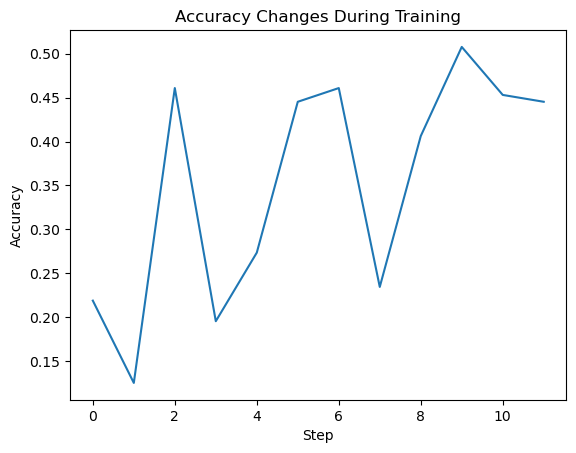

In [318]:
spiking_model_4layer_multiclass = Pulse_Network_4layer_multiclass(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_4layer_multiclass)

A hidden neuron that looks excited:


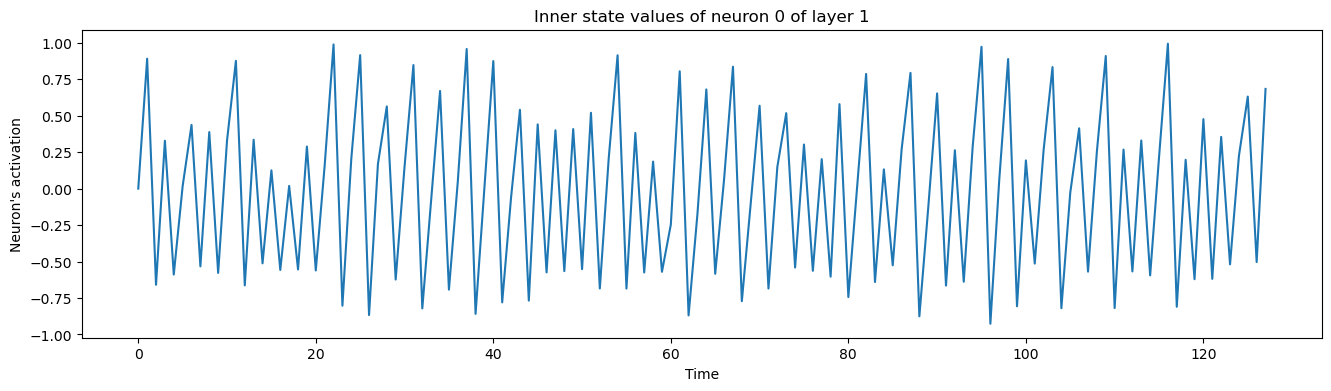

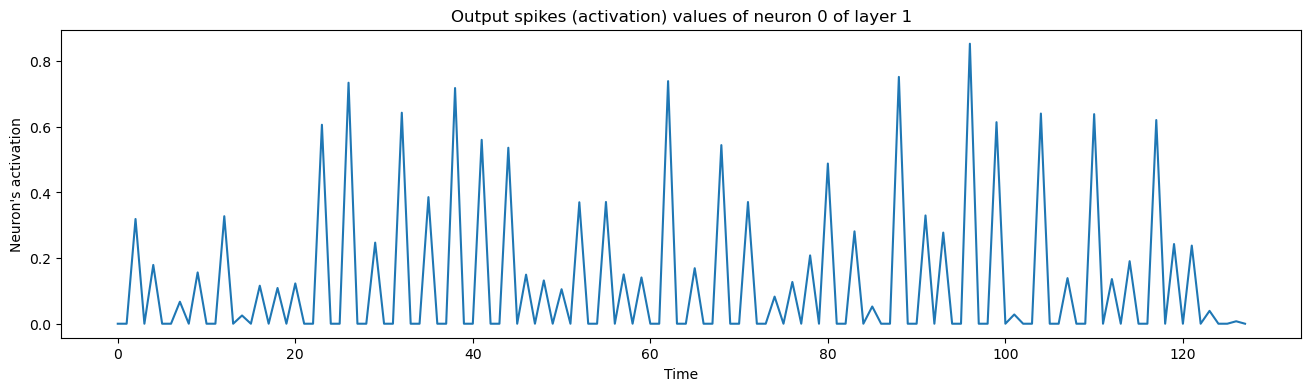

The output neuron of the label:


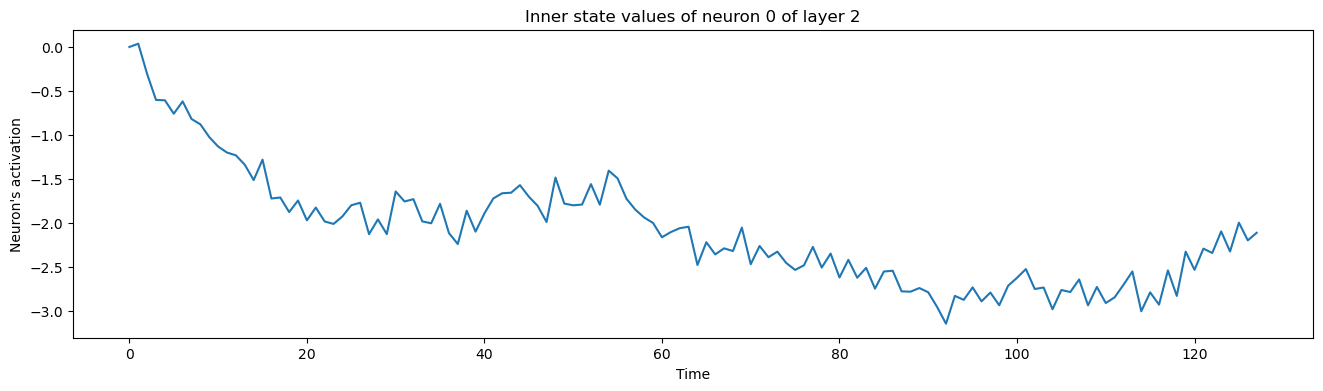

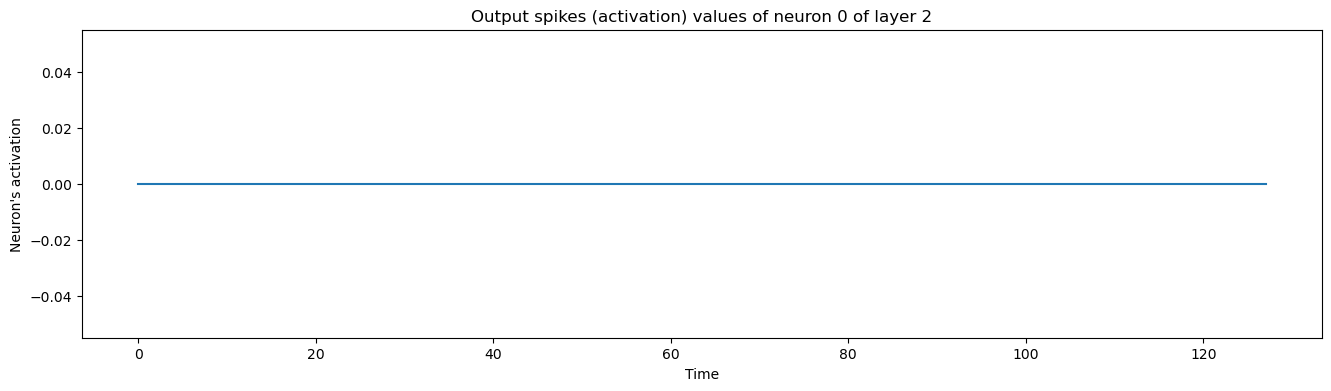

In [322]:
print("A hidden neuron that looks excited:")
spiking_model_4layer_multiclass.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model_4layer_multiclass.visualize_neuron(x, layer_idx=1, neuron_idx=y)


Test set: Average loss: 2.1117, Accuracy: 495/1127 (43.92%)

Accuracy of the model: 43.92%


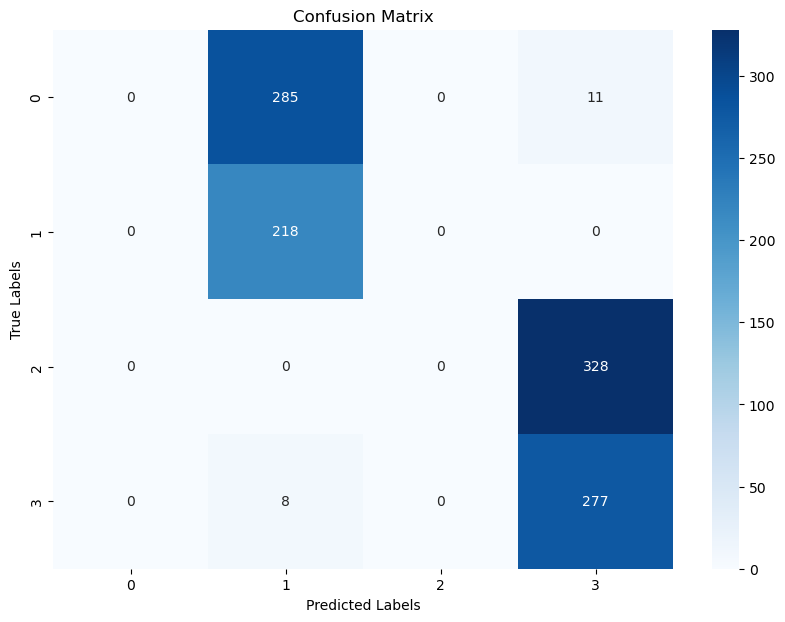

In [325]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


conf_matrix_4layer_multiclass, accuracy_4layer_multiclass = test(spiking_model_4layer_multiclass, device, test_set_loader)  

print("Accuracy of the model: {:.2f}%".format(100. * accuracy_4layer_multiclass))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_4layer_multiclass, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# comparison between 2,3 and 4 layer SNN model for Multi class classification

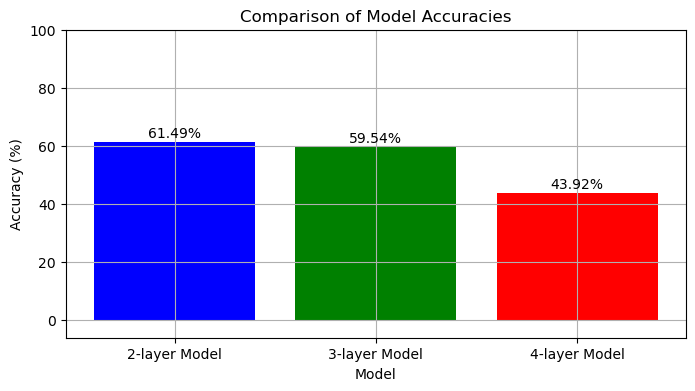

In [328]:
import matplotlib.pyplot as plt


accuracy_scores = {
    '2-layer Model': accuracy_2layer_multiclass,
    '3-layer Model': accuracy_3layer_multiclass,
    '4-layer Model': accuracy_4layer_multiclass
}

# Set up the matplotlib figure
plt.figure(figsize=(8, 4))

# Create a bar chart
models = list(accuracy_scores.keys())
accuracies = [100 * accuracy_scores[model] for model in models]  # Convert to percentages
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.grid(True)
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim([min(accuracies) - 50, 100])  

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

plt.show()


# Binary Classification Using SNN with Small dataset

In [344]:
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [345]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Define transformation
transform = Compose([
    Resize((64, 64)), 
    ToTensor(),        
    Normalize(mean=[0.5], std=[0.5])  
])

dataset_path = './M_data'  
dataset = ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_set_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_set_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Training Data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

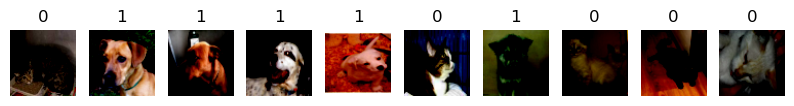

Testing Data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

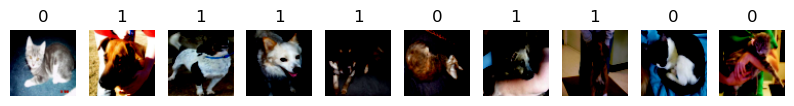

In [346]:
import matplotlib.pyplot as plt

def show_images(dataloader):
    
    for images, labels in dataloader:
        plt.figure(figsize=(10, 10))  
        for i in range(10, 20): 
            plt.subplot(1, 10, i - 9)
            plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  
            plt.title(labels[i].item())  
            plt.axis('off')  
        plt.show()
        break  
print("Training Data:")
show_images(train_set_loader)
print("Testing Data:")
show_images(test_set_loader)


In [347]:
def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    model.train()
    accuracies = [] 
    
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            accuracies.append(correct)
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
    
    return accuracies

In [348]:
def train_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    accuracies = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    
    plot_accuracies(accuracies)

In [349]:
def test(model, device, test_set_loader):

    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f},\n Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")

In [350]:
def plot_accuracies(accuracies):
    plt.plot(accuracies)
    plt.title('Accuracy Changes During Training')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.show()


# Binary Classification Using 2 Layer SNN model with small Dataset

In [351]:
class RNN_Spiking_Neuron(nn.Module):
    
    def __init__(self, computation_device, n_inputs=64*64, n_hidden=100, decay_multiplier=0.9, 
                 threshold=2.0, penalty_threshold=2.5):
        super(RNN_Spiking_Neuron, self).__init__()
        self.computation_device = computation_device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.computation_device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.computation_device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.computation_device)

    def forward(self, x):
    
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])

        input_excitation = self.fc(x)
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        outer_excitation = F.relu(inner_excitation - self.threshold)
        do_penalize_gate = (outer_excitation > 0).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * 
                                               inner_excitation) * do_penalize_gate
        outer_excitation = outer_excitation
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output

In [352]:
class Input_layer(nn.Module):
    
    def __init__(self, computation_device):
        super(Input_layer, self).__init__()
        self.computation_device = computation_device
        
        self.reset_state()
        self.to(self.computation_device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.computation_device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  
        random_activation_perceptron = torch.rand(x.shape).to(self.computation_device)
        return random_activation_perceptron * x


In [353]:
class Output_layer(nn.Module):
    
    def __init__(self, average_output=True):
      
        super(Output_layer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


In [354]:

class Pulse_Network(nn.Module):
    def __init__(self, computation_device, n_time_steps, begin_eval):
        super(Pulse_Network, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.computation_device = computation_device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(computation_device)
        
        self.layer1 = RNN_Spiking_Neuron(
            computation_device, n_inputs=64*64*3, n_hidden=100,  
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            computation_device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False) 
        
        self.to(self.computation_device)

    
    def forward_through_time(self, x):
 
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)

            layer1_state, layer1_output = self.layer1(xi)
          
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)
   
    def Display_neurons(self, x, width=None, height=None):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

            self.plot_layer(layer_state, title="Values of the internal state neurons for layer {}".format(i), width=width, height=height)
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i), width=width, height=height)
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Values of the internal state of neuron {} in layer {}.".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Activation values (spikes) of neuron {} in layer {}.".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title, width=None, height=None):
        if width is None:
            width = max(5, layer_values.shape[0] / 8)
        if height is None:
            height = max(5, layer_values.shape[1] / 8)

        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(5, len(neuron_through_time) / 8)
        height = 5
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.grid(True)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()



Train Epoch: 1 [0/1599 (0%)] Loss: 2.111550 Accuracy: 29.69%
Train Epoch: 1 [1280/1599 (77%)] Loss: 0.749591 Accuracy: 50.00%

Test set: Average loss: 0.0072,
 Accuracy: 208/400 (52.00%)

Train Epoch: 2 [0/1599 (0%)] Loss: 0.765808 Accuracy: 47.66%
Train Epoch: 2 [1280/1599 (77%)] Loss: 0.718277 Accuracy: 52.34%

Test set: Average loss: 0.0070,
 Accuracy: 221/400 (55.25%)

Train Epoch: 3 [0/1599 (0%)] Loss: 0.717599 Accuracy: 52.34%
Train Epoch: 3 [1280/1599 (77%)] Loss: 0.706812 Accuracy: 46.09%

Test set: Average loss: 0.0068,
 Accuracy: 230/400 (57.50%)



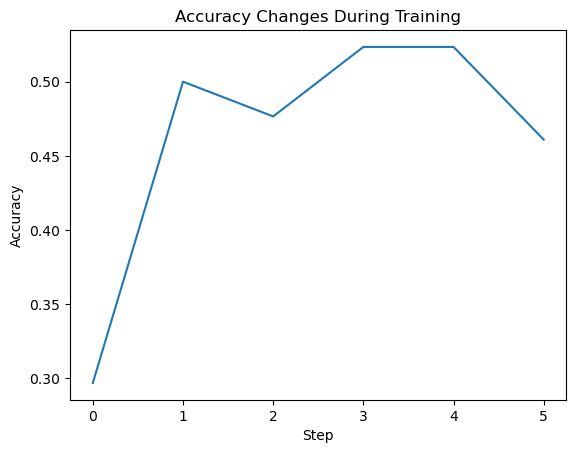

In [355]:
spiking_model_2layers_minimum_data = Pulse_Network(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_2layers_minimum_data)

In [358]:
def train_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    accuracies = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    epoch = 4
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    epoch = 5
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    epoch = 6
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    epoch = 7
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    epoch = 8
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    epoch = 9
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    epoch = 10
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    accuracies += train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
    
    plot_accuracies(accuracies)

Train Epoch: 1 [0/1599 (0%)] Loss: 2.211908 Accuracy: 7.03%
Train Epoch: 1 [1280/1599 (77%)] Loss: 0.731881 Accuracy: 46.09%

Test set: Average loss: 0.0074,
 Accuracy: 219/400 (54.75%)

Train Epoch: 2 [0/1599 (0%)] Loss: 0.729497 Accuracy: 45.31%
Train Epoch: 2 [1280/1599 (77%)] Loss: 0.738966 Accuracy: 46.09%

Test set: Average loss: 0.0068,
 Accuracy: 229/400 (57.25%)

Train Epoch: 3 [0/1599 (0%)] Loss: 0.661225 Accuracy: 63.28%
Train Epoch: 3 [1280/1599 (77%)] Loss: 0.699258 Accuracy: 53.91%

Test set: Average loss: 0.0069,
 Accuracy: 237/400 (59.25%)

Train Epoch: 4 [0/1599 (0%)] Loss: 0.698914 Accuracy: 53.12%
Train Epoch: 4 [1280/1599 (77%)] Loss: 0.657035 Accuracy: 60.94%

Test set: Average loss: 0.0068,
 Accuracy: 242/400 (60.50%)

Train Epoch: 5 [0/1599 (0%)] Loss: 0.660905 Accuracy: 61.72%
Train Epoch: 5 [1280/1599 (77%)] Loss: 0.656295 Accuracy: 62.50%

Test set: Average loss: 0.0070,
 Accuracy: 230/400 (57.50%)

Train Epoch: 6 [0/1599 (0%)] Loss: 0.692271 Accuracy: 55.47%


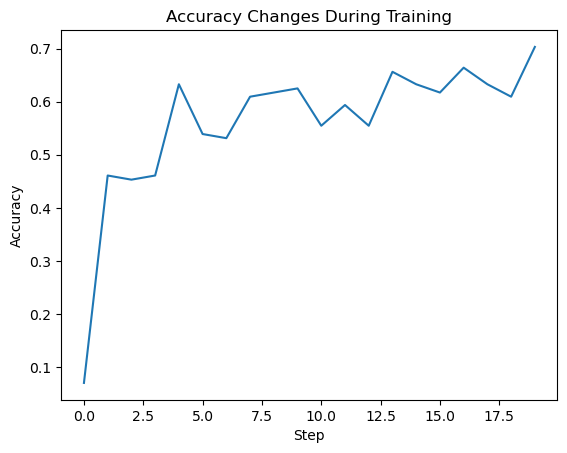

In [359]:
spiking_model_2layers_minimum_data_more_epochs = Pulse_Network(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_2layers_minimum_data_more_epochs)

A hidden neuron that looks excited:


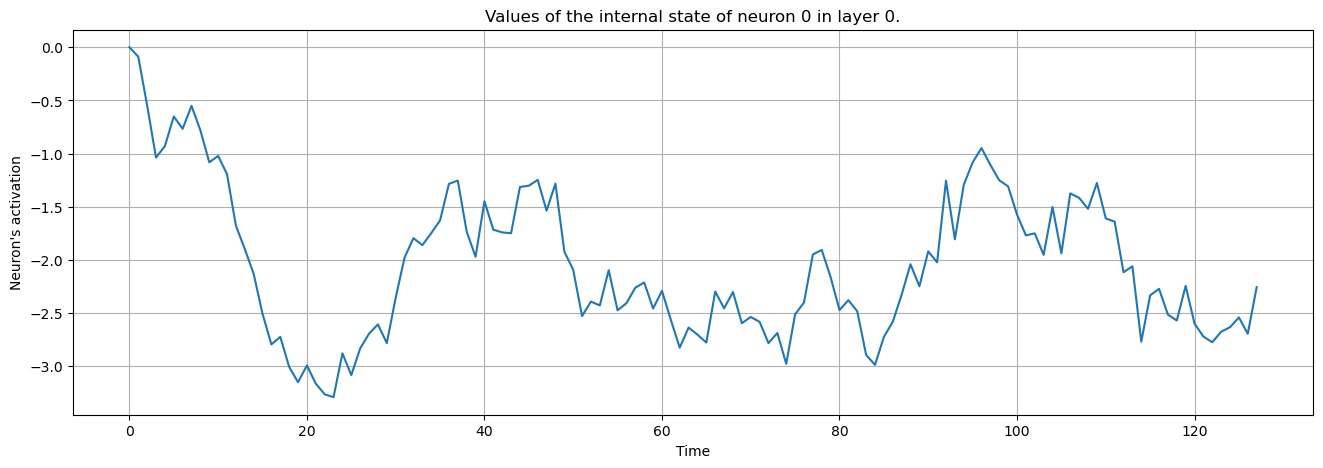

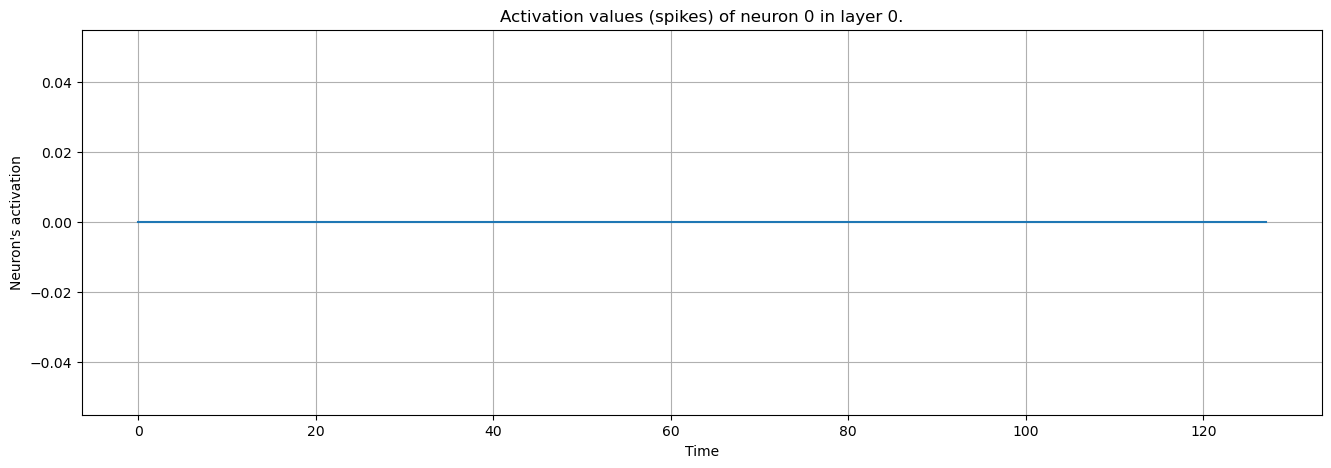

The output neuron of the label:


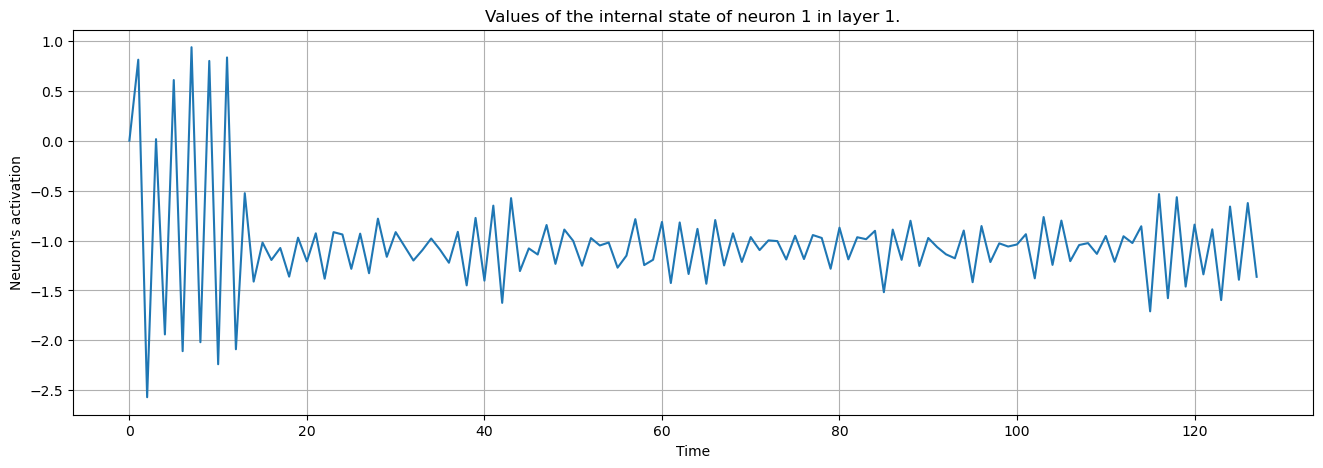

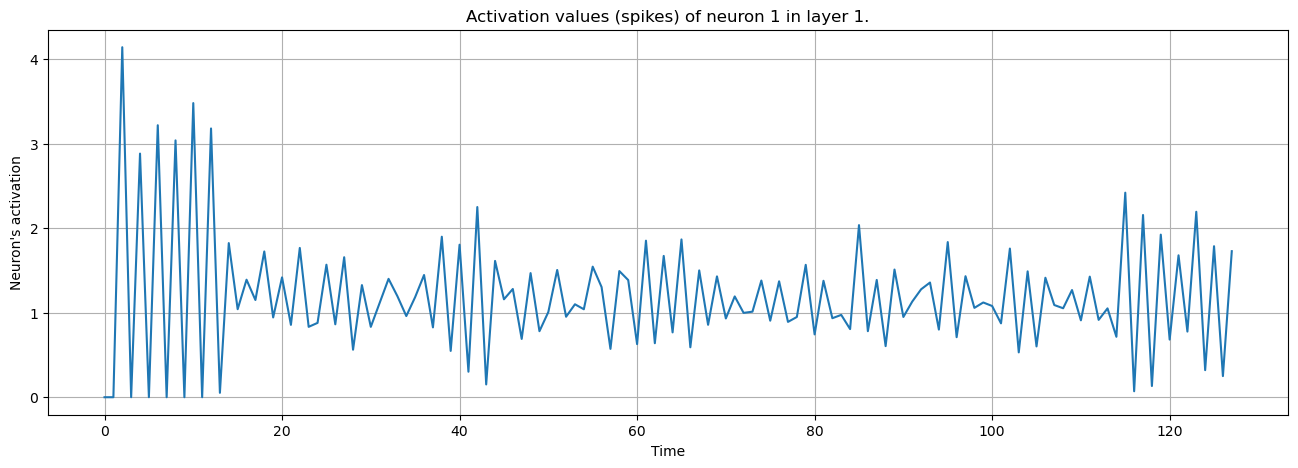

In [373]:
print("A hidden neuron that looks excited:")
spiking_model_2layers_minimum_data_more_epochs.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model_2layers_minimum_data_more_epochs.visualize_neuron(x, layer_idx=1, neuron_idx=y)


Test set: Average loss: 0.6554, Accuracy: 243/400 (60.75%)

Accuracy of the model: 60.75%


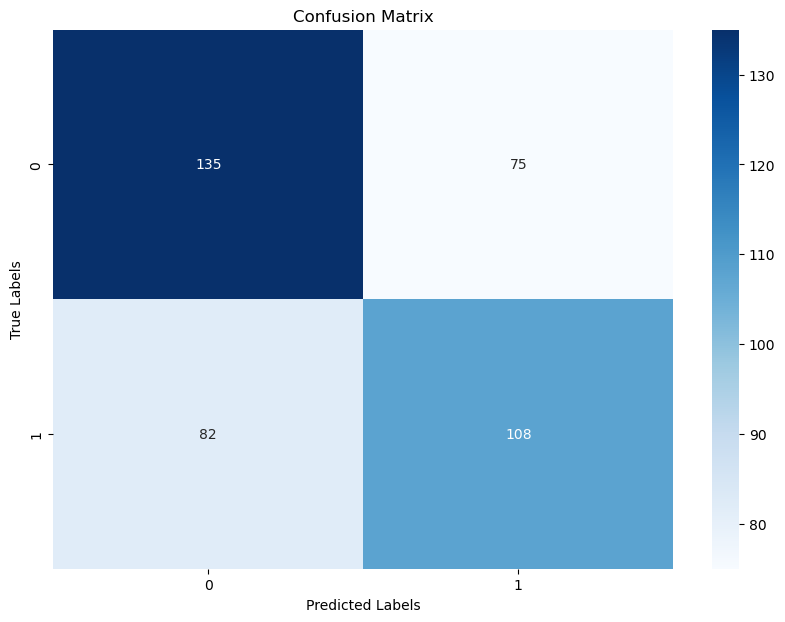

In [384]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix_2layers_minimum_data_more_epochs, accuracy_2layers_minimum_data_more_epochs = test(spiking_model_2layers_minimum_data_more_epochs, device, test_set_loader) 

print("Accuracy of the model: {:.2f}%".format(100. * accuracy_2layers_minimum_data_more_epochs))

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_2layers_minimum_data_more_epochs, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Binary Classification Using 3 Layer SNN model with small Dataset

In [361]:

class Pulse_Network_3layer(nn.Module):
    def __init__(self, computation_device, n_time_steps, begin_eval):
        super(Pulse_Network_3layer, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.computation_device = computation_device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(computation_device)
        
        self.layer1 = RNN_Spiking_Neuron(
            computation_device, n_inputs=64*64*3, n_hidden=100, 
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            computation_device, n_inputs=100, n_hidden=50, 
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

      
        self.layer3 = RNN_Spiking_Neuron(
            computation_device, n_inputs=50, n_hidden=10,  
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False)  
        
        self.to(self.computation_device)
    
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state()  

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = []  
        all_layer3_outputs = []  
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # Processing through layers
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output)  
            
            # Appending states and outputs for visualization
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state) 
            all_layer3_outputs.append(layer3_output)  
            out.append(layer3_state)  
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs], [all_layer3_states, all_layer3_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)
    
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state() 

        out = []
        
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = [] 
        all_layer3_outputs = []  
        
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # Process through each layer
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output)  
            
            # Append states and outputs for each layer
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state) 
            all_layer3_outputs.append(layer3_output) 
            out.append(layer3_output)  
            
       
        out = self.output_conversion(torch.stack(out[self.begin_eval:]))
        return out, [[all_layer1_states, all_layer1_outputs], 
                     [all_layer2_states, all_layer2_outputs], 
                     [all_layer3_states, all_layer3_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)


    def Display_neurons(self, x, width=None, height=None):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network_3layer.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Values of the internal state neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network_3layer.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Values of the internal state of neuron {} in layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title, width=None, height=None):
        if width is None:
            width = max(5, layer_values.shape[0] / 8)
        if height is None:
            height = max(5, layer_values.shape[1] / 8)

        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(5, len(neuron_through_time) / 8)
        height = 5
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.grid(True)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

Train Epoch: 1 [0/1599 (0%)] Loss: 2.302331 Accuracy: 50.00%
Train Epoch: 1 [1280/1599 (77%)] Loss: 2.268604 Accuracy: 53.12%

Test set: Average loss: 0.0225,
 Accuracy: 190/400 (47.50%)

Train Epoch: 2 [0/1599 (0%)] Loss: 2.251983 Accuracy: 51.56%
Train Epoch: 2 [1280/1599 (77%)] Loss: 2.243021 Accuracy: 47.66%

Test set: Average loss: 0.0220,
 Accuracy: 190/400 (47.50%)

Train Epoch: 3 [0/1599 (0%)] Loss: 2.212644 Accuracy: 49.22%
Train Epoch: 3 [1280/1599 (77%)] Loss: 2.102014 Accuracy: 49.22%

Test set: Average loss: 0.0198,
 Accuracy: 190/400 (47.50%)

Train Epoch: 4 [0/1599 (0%)] Loss: 1.960666 Accuracy: 53.91%
Train Epoch: 4 [1280/1599 (77%)] Loss: 1.363521 Accuracy: 62.50%

Test set: Average loss: 0.0143,
 Accuracy: 196/400 (49.00%)

Train Epoch: 5 [0/1599 (0%)] Loss: 1.508443 Accuracy: 46.88%
Train Epoch: 5 [1280/1599 (77%)] Loss: 1.085551 Accuracy: 57.03%

Test set: Average loss: 0.0138,
 Accuracy: 190/400 (47.50%)

Train Epoch: 6 [0/1599 (0%)] Loss: 1.283383 Accuracy: 57.81%

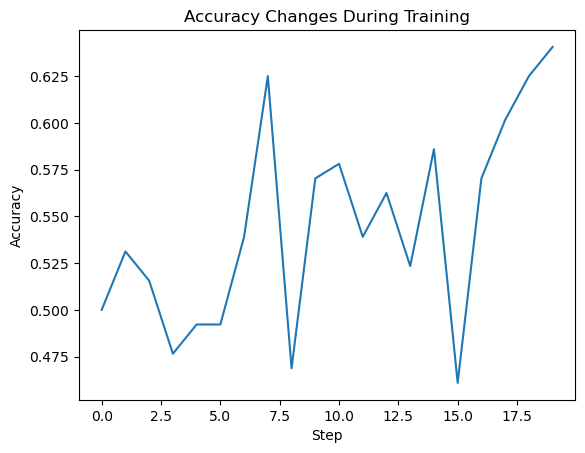

In [362]:
spiking_model_3layers_minimum_data_more_epochs = Pulse_Network_3layer(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_3layers_minimum_data_more_epochs)

A hidden neuron that looks excited:


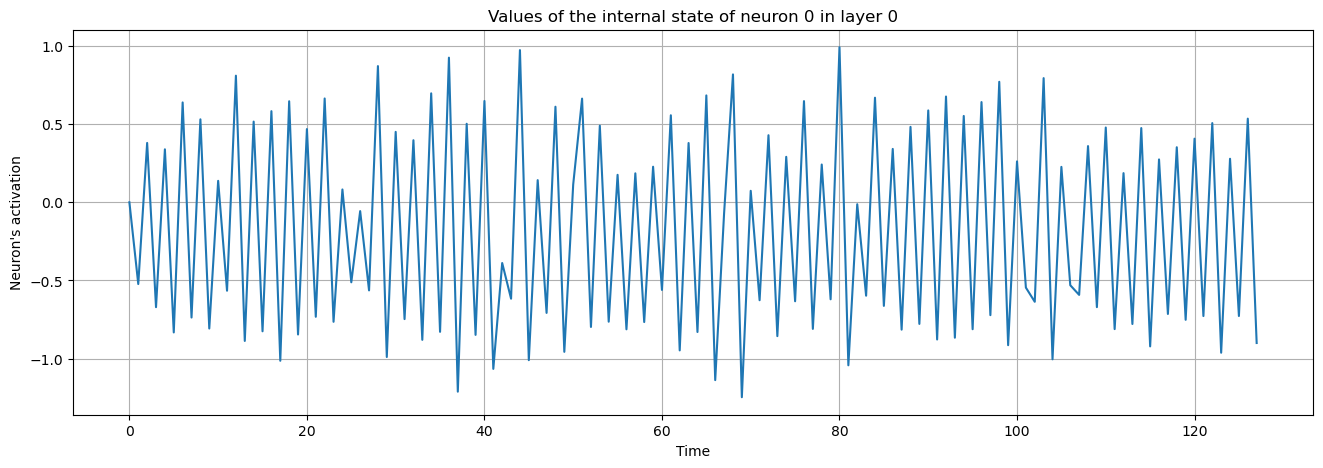

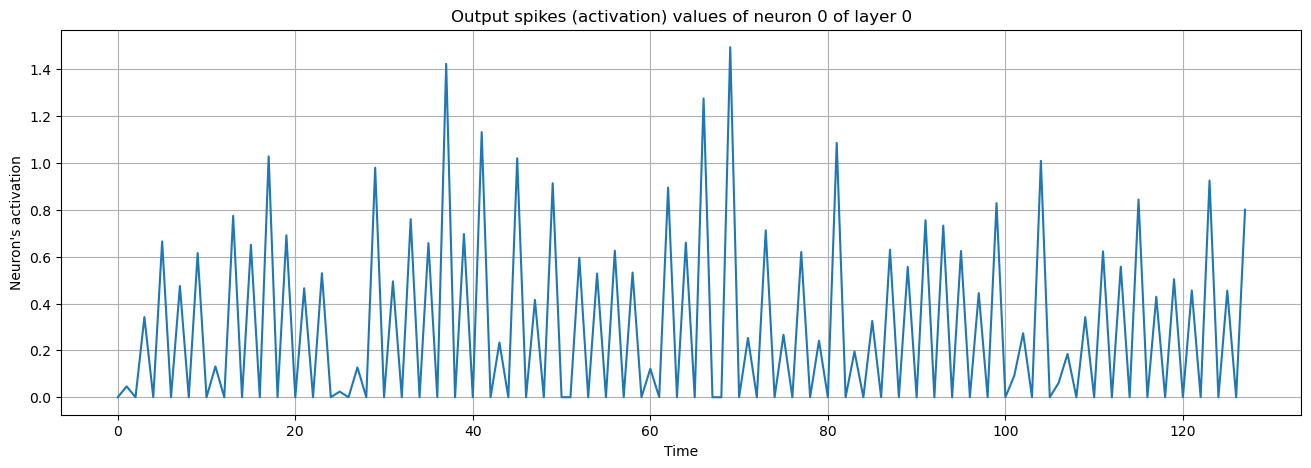

The output neuron of the label:


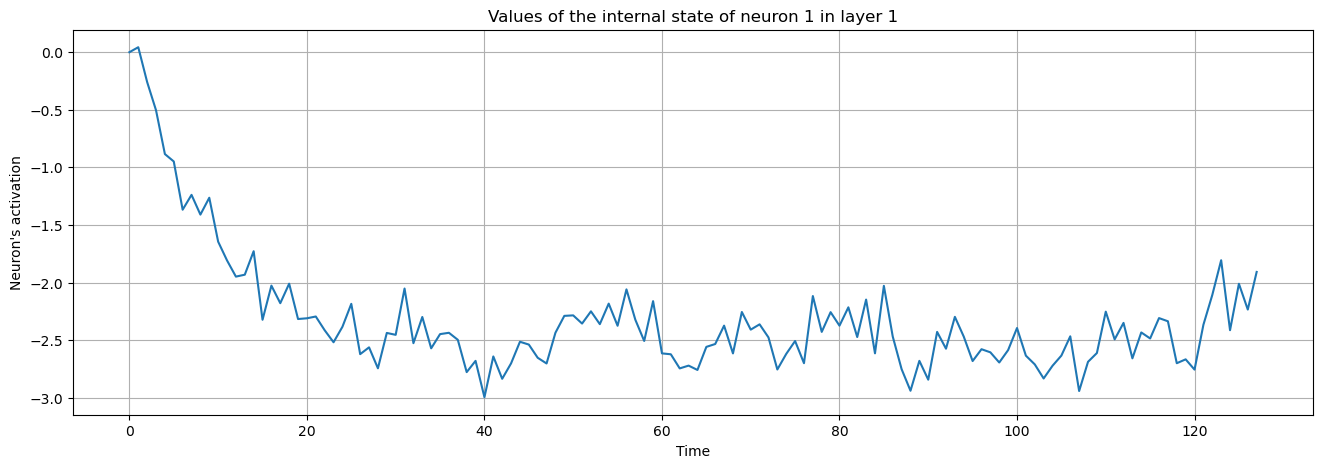

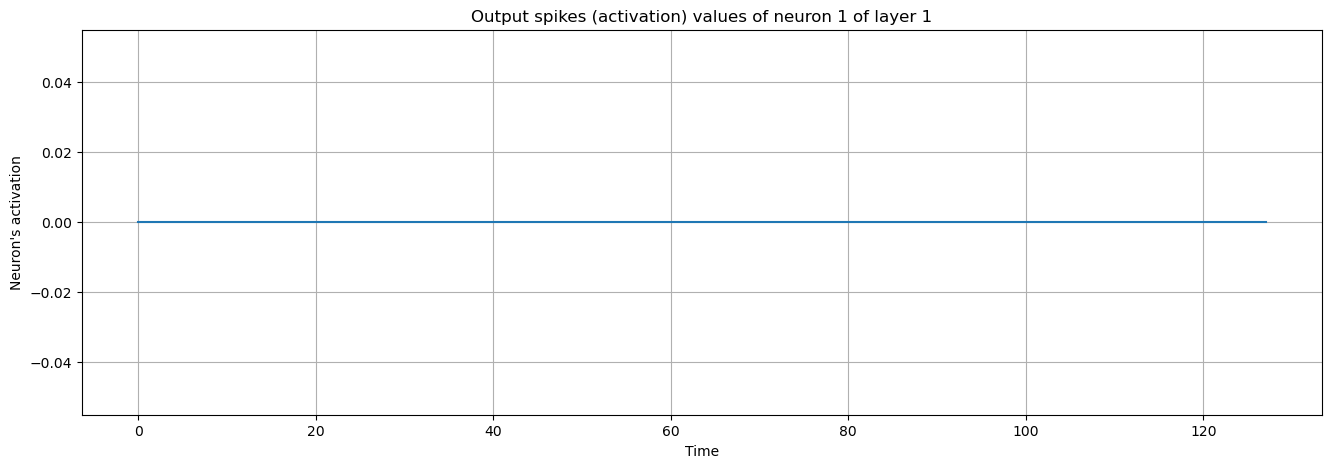

In [370]:
print("A hidden neuron that looks excited:")
spiking_model_3layers_minimum_data_more_epochs.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model_3layers_minimum_data_more_epochs.visualize_neuron(x, layer_idx=1, neuron_idx=y)


Test set: Average loss: 0.7684, Accuracy: 234/400 (58.50%)

Accuracy of the model: 41.35%


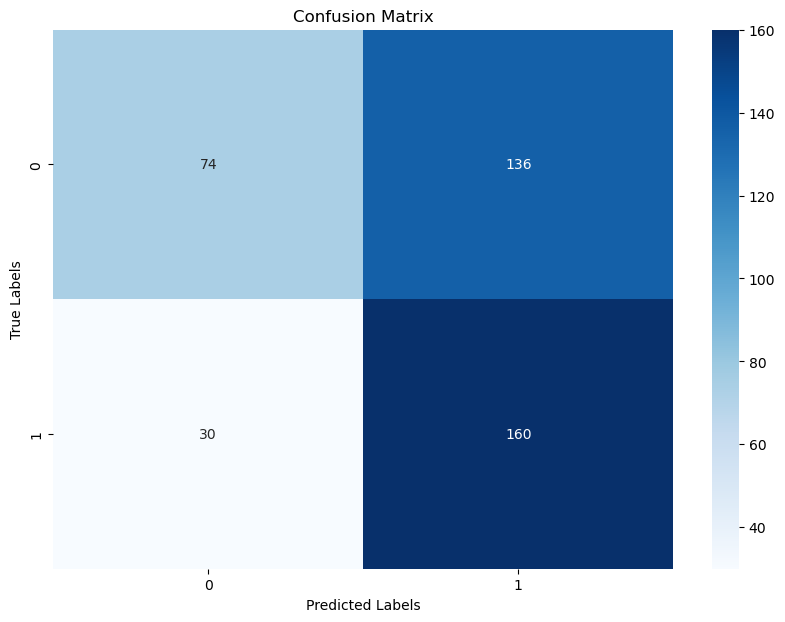

In [371]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


conf_matrix_3layers_minimum_data_more_epochs, accuracy_3layers_minimum_data_more_epochs = test(spiking_model_3layers_minimum_data_more_epochs, device, test_set_loader) 

print("Accuracy of the model: {:.2f}%".format(100. * accuracy_2layer))

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_3layers_minimum_data_more_epochs, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Binary Classification Using 4 Layer SNN model with small Dataset

In [364]:

class Pulse_Network_4layer(nn.Module):
    def __init__(self, computation_device, n_time_steps, begin_eval):
        super(Pulse_Network_4layer, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.computation_device = computation_device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = Input_layer(computation_device)
        
        self.layer1 = RNN_Spiking_Neuron(
            computation_device, n_inputs=64*64*3, n_hidden=100,  # Adjust for your input dimension
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = RNN_Spiking_Neuron(
            computation_device, n_inputs=100, n_hidden=50,  # Adjust hidden units as needed
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.layer3 = RNN_Spiking_Neuron(
            computation_device, n_inputs=50, n_hidden=30,  # New layer 3 configuration
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.layer4 = RNN_Spiking_Neuron(  # New layer 4
            computation_device, n_inputs=30, n_hidden=10,  # Adjust inputs/outputs as needed for layer 4
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = Output_layer(average_output=False)
        
        self.to(self.computation_device)
    
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state()
        self.layer4.reset_state()  

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = []
        all_layer3_outputs = []
        all_layer4_states = []  
        all_layer4_outputs = []  
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # Processing through layers
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
            layer3_state, layer3_output = self.layer3(layer2_output)
            layer4_state, layer4_output = self.layer4(layer3_output)  
            
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state)
            all_layer3_outputs.append(layer3_output)
            all_layer4_states.append(layer4_state)  
            all_layer4_outputs.append(layer4_output) 
            out.append(layer4_output) 
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs], [all_layer3_states, all_layer3_outputs], [all_layer4_states, all_layer4_outputs]]  # Include layer 4 in return
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)



  
    def Display_neurons(self, x, width=None, height=None):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network_4layer.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
        
            self.plot_layer(layer_state, title=f"Inner state values of neurons for layer {i+1}")
            self.plot_layer(layer_output, title=f"Output spikes (activation) values of neurons for layer {i+1}")

    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to Pulse_Network.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]

        layer_state = torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title=f"Inner state values of neuron {neuron_idx} of layer {layer_idx+1}")
        self.plot_neuron(layer_output[neuron_idx], title=f"Output spikes (activation) values of neuron {neuron_idx} of layer {layer_idx+1}")

    def plot_layer(self, layer_values, title, width=None, height=None):
        if width is None:
            width = max(5, layer_values.shape[0] / 8)
        if height is None:
            height = max(5, layer_values.shape[1] / 8)

        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(5, len(neuron_through_time) / 8)
        height = 5
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.grid(True)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()


Train Epoch: 1 [0/1599 (0%)] Loss: 2.302636 Accuracy: 0.00%
Train Epoch: 1 [1280/1599 (77%)] Loss: 2.285360 Accuracy: 55.47%

Test set: Average loss: 0.0225,
 Accuracy: 210/400 (52.50%)

Train Epoch: 2 [0/1599 (0%)] Loss: 2.242459 Accuracy: 55.47%
Train Epoch: 2 [1280/1599 (77%)] Loss: 2.255462 Accuracy: 45.31%

Test set: Average loss: 0.0223,
 Accuracy: 210/400 (52.50%)

Train Epoch: 3 [0/1599 (0%)] Loss: 2.225652 Accuracy: 52.34%
Train Epoch: 3 [1280/1599 (77%)] Loss: 2.181823 Accuracy: 46.88%

Test set: Average loss: 0.0215,
 Accuracy: 210/400 (52.50%)

Train Epoch: 4 [0/1599 (0%)] Loss: 2.175400 Accuracy: 44.53%
Train Epoch: 4 [1280/1599 (77%)] Loss: 2.098527 Accuracy: 50.78%

Test set: Average loss: 0.0208,
 Accuracy: 210/400 (52.50%)

Train Epoch: 5 [0/1599 (0%)] Loss: 2.070415 Accuracy: 53.12%
Train Epoch: 5 [1280/1599 (77%)] Loss: 2.079249 Accuracy: 50.00%

Test set: Average loss: 0.0214,
 Accuracy: 210/400 (52.50%)

Train Epoch: 6 [0/1599 (0%)] Loss: 2.106058 Accuracy: 54.69%


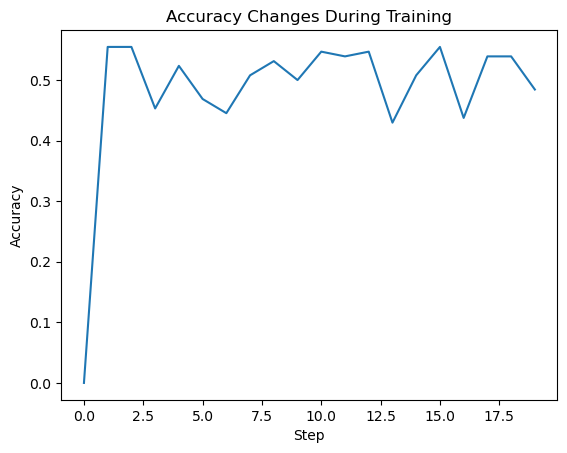

In [365]:
spiking_model_4layers_minimum_data_more_epochs = Pulse_Network_4layer(device, n_time_steps=128, begin_eval=0)
train_epochs(spiking_model_4layers_minimum_data_more_epochs)

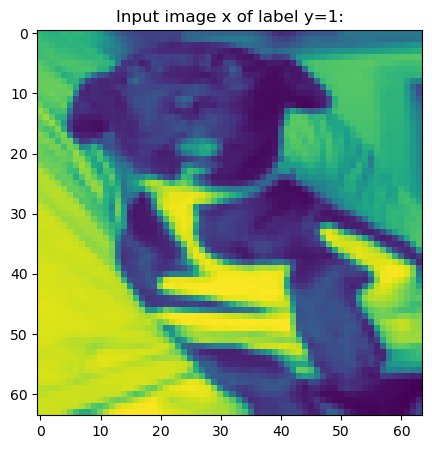

In [366]:
data, target = test_set_loader.__iter__().__next__()

x = torch.stack([data[2]]) 
y = target.data.numpy()[2]
plt.figure(figsize=(5,5))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()


A hidden neuron that looks excited:


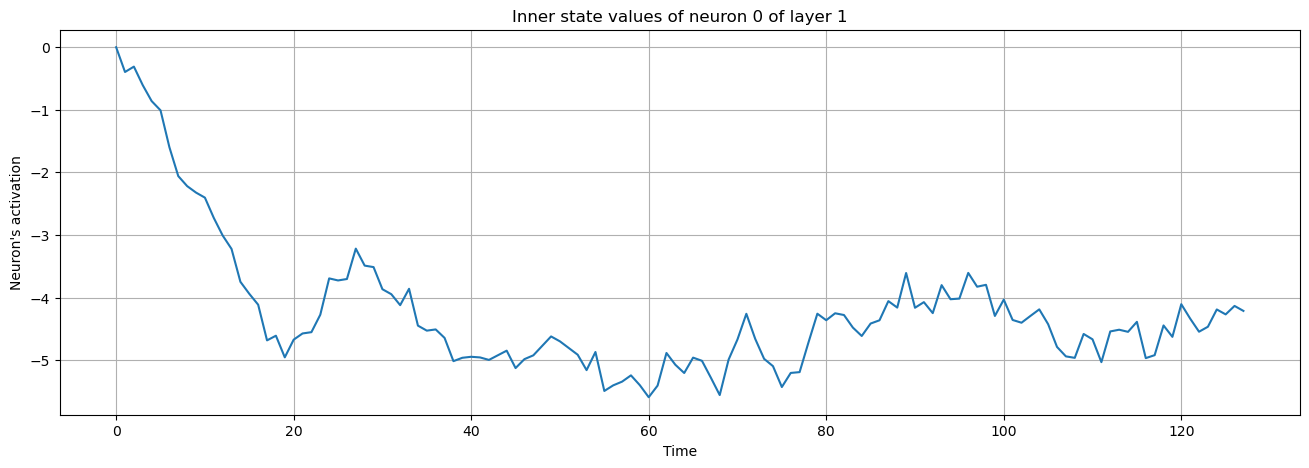

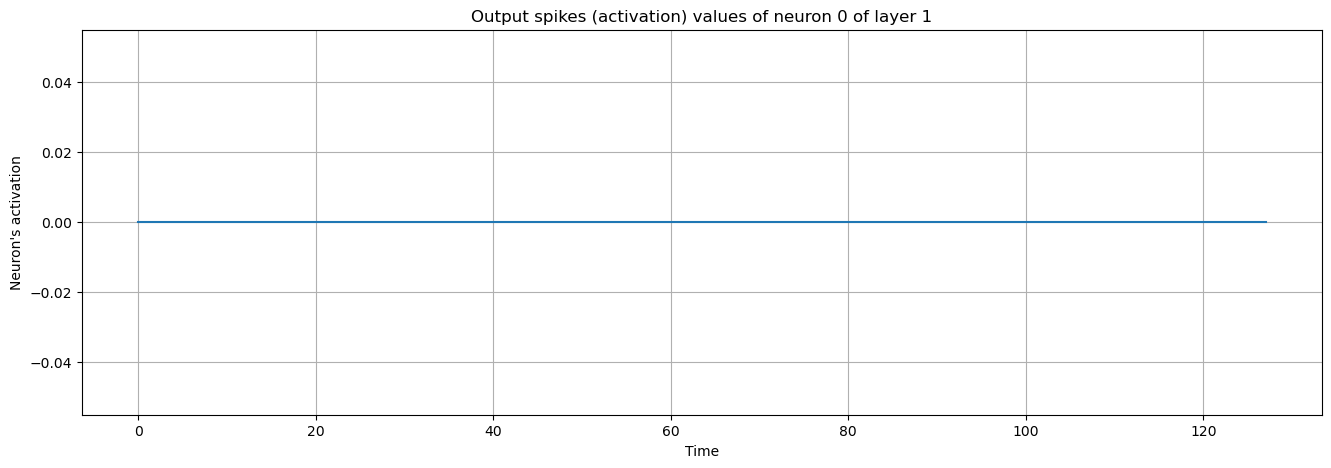

The output neuron of the label:


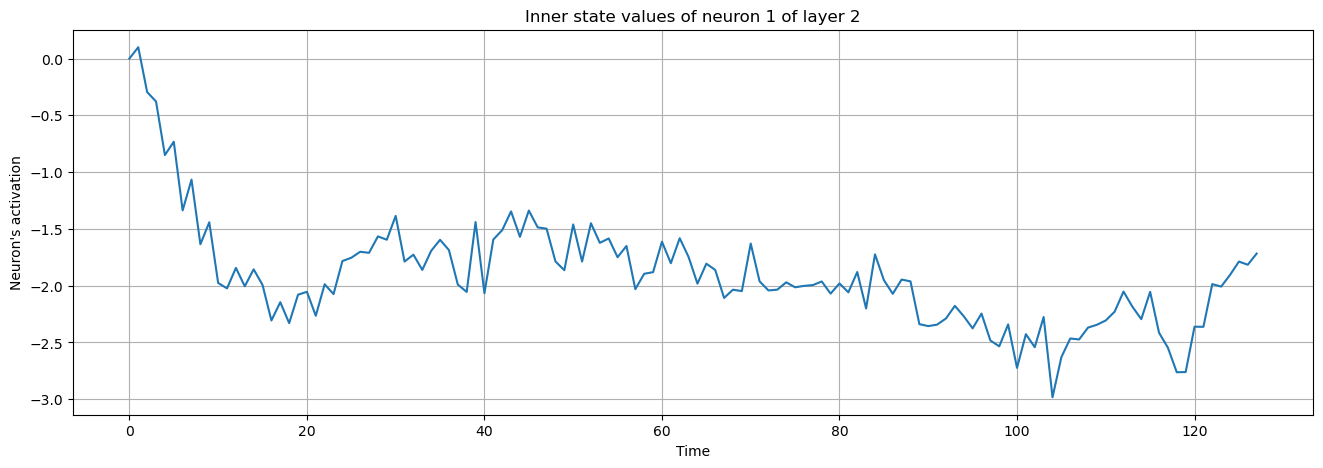

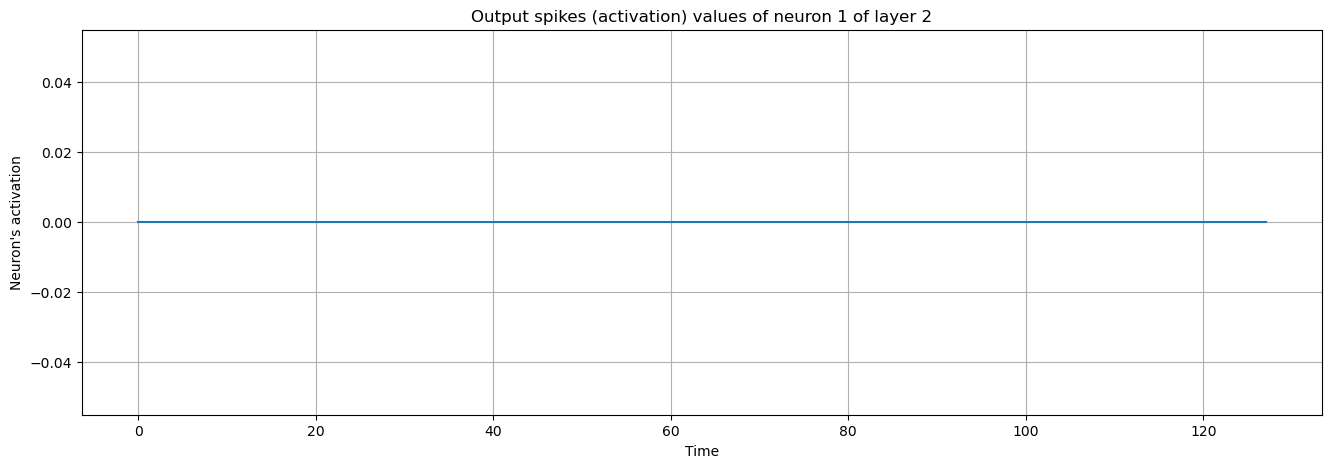

In [367]:
print("A hidden neuron that looks excited:")
spiking_model_4layers_minimum_data_more_epochs.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model_4layers_minimum_data_more_epochs.visualize_neuron(x, layer_idx=1, neuron_idx=y)

# comparison between 2,3 and 4 layer SNN model using small dataset

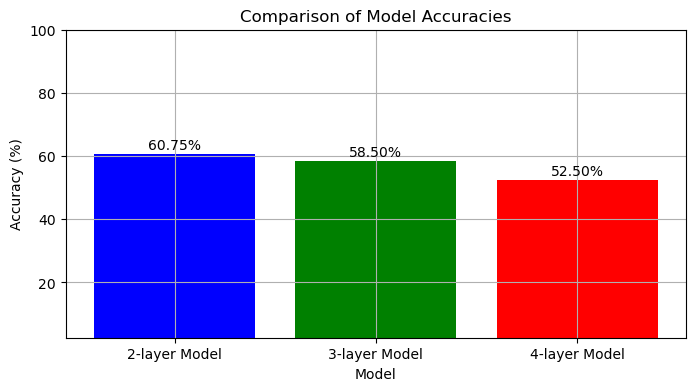

In [376]:
import matplotlib.pyplot as plt


accuracy_scores = {
    '2-layer Model': accuracy_2layers_minimum_data_more_epochs,
    '3-layer Model': accuracy_3layers_minimum_data_more_epochs,
    '4-layer Model': accuracy_4layers_minimum_data_more_epochs
}

plt.figure(figsize=(8, 4))

models = list(accuracy_scores.keys())
accuracies = [100 * accuracy_scores[model] for model in models]  # Convert to percentages
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.grid(True)
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim([min(accuracies) - 50, 100])  

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

plt.show()


# comparison between small dataset and large dataset

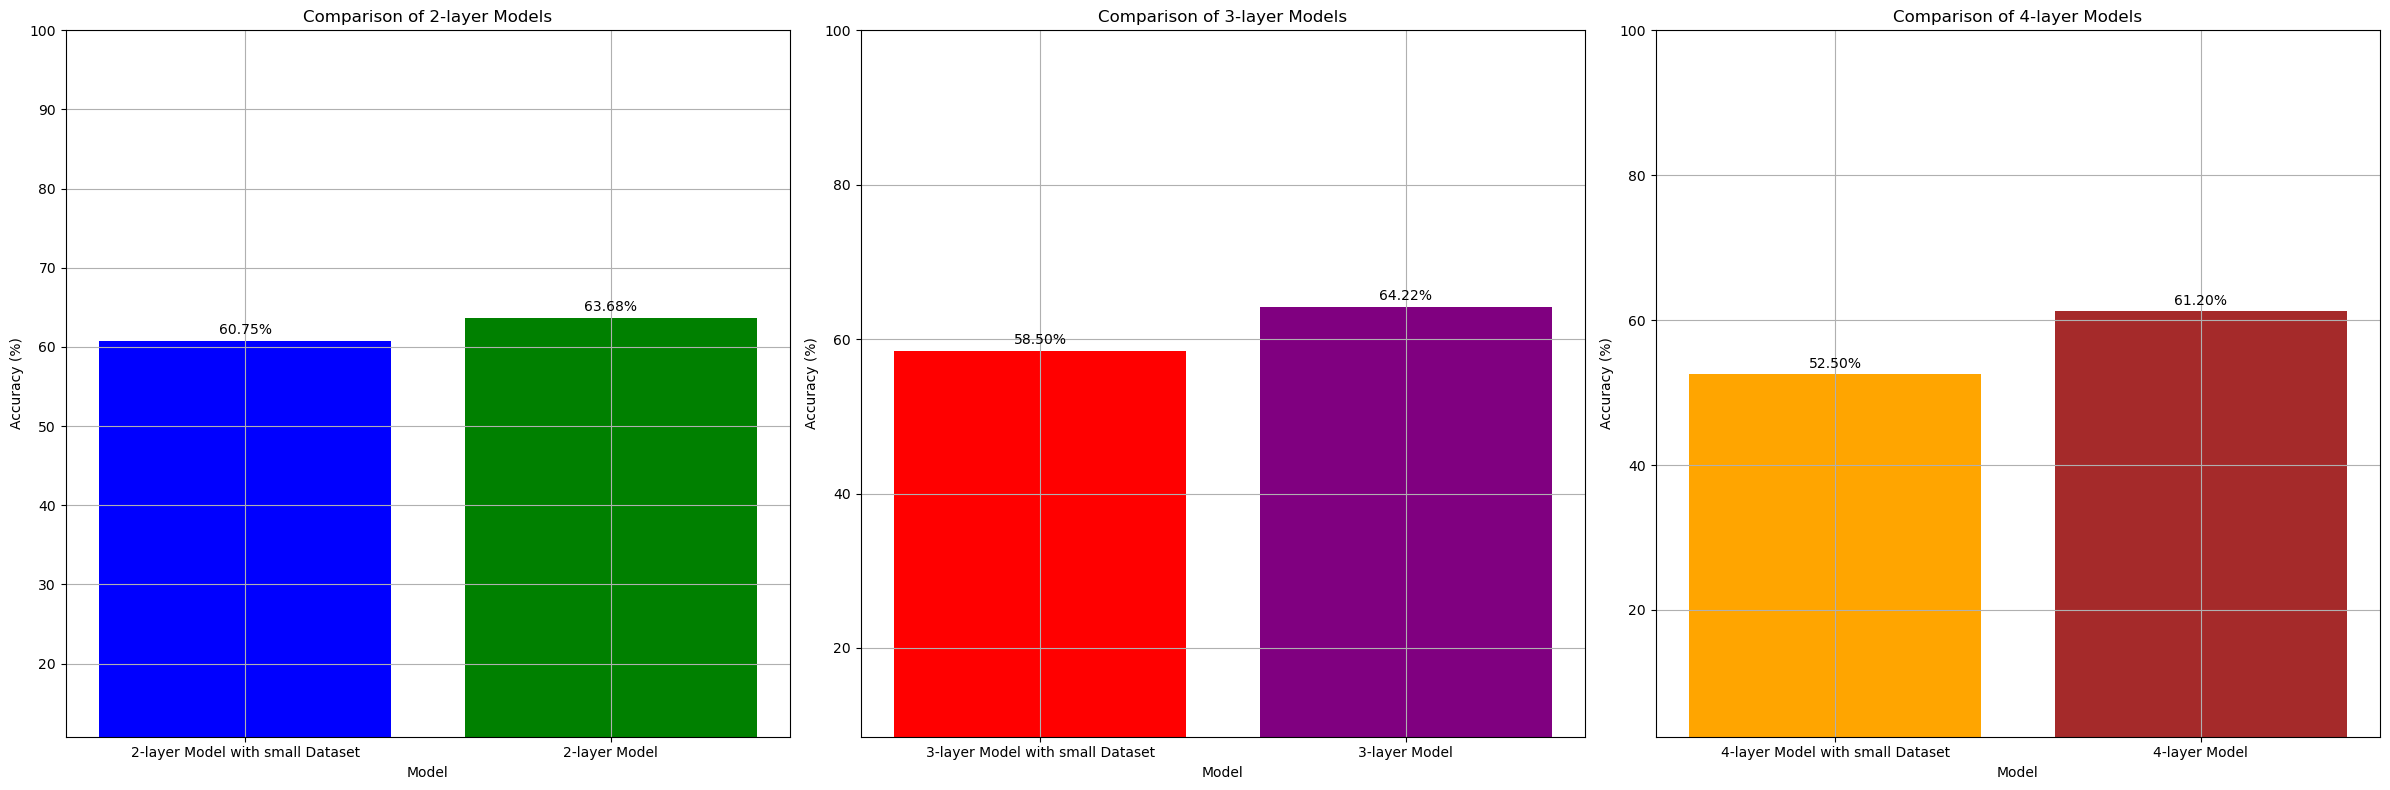

In [411]:
import matplotlib.pyplot as plt

accuracy_scores_1 = {
    '2-layer Model with small Dataset': accuracy_2layers_minimum_data_more_epochs,
    '2-layer Model': accuracy_2layer,
}
accuracy_scores_2 = {
    '3-layer Model with small Dataset': accuracy_3layers_minimum_data_more_epochs,
    '3-layer Model': accuracy_3layer,
}
accuracy_scores_3 = {
    '4-layer Model with small Dataset': accuracy_4layers_minimum_data_more_epochs,
    '4-layer Model': accuracy_4layer,
}

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

def plot_accuracy_graph(ax, accuracy_scores, title, colors):
    models = list(accuracy_scores.keys())
    accuracies = [100 * accuracy_scores[model] for model in models]     
    ax.bar(models, accuracies, color=colors)
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim([min(accuracies) - 50, 100])    
    for i, v in enumerate(accuracies):
        ax.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

fig, axs = plt.subplots(1, 3, figsize=(24, 8)) 
plot_accuracy_graph(axs[0], accuracy_scores_1, 'Comparison of 2-layer Models', colors[:2])
plot_accuracy_graph(axs[1], accuracy_scores_2, 'Comparison of 3-layer Models', colors[2:4])
plot_accuracy_graph(axs[2], accuracy_scores_3, 'Comparison of 4-layer Models', colors[4:6])

plt.tight_layout()
plt.show()


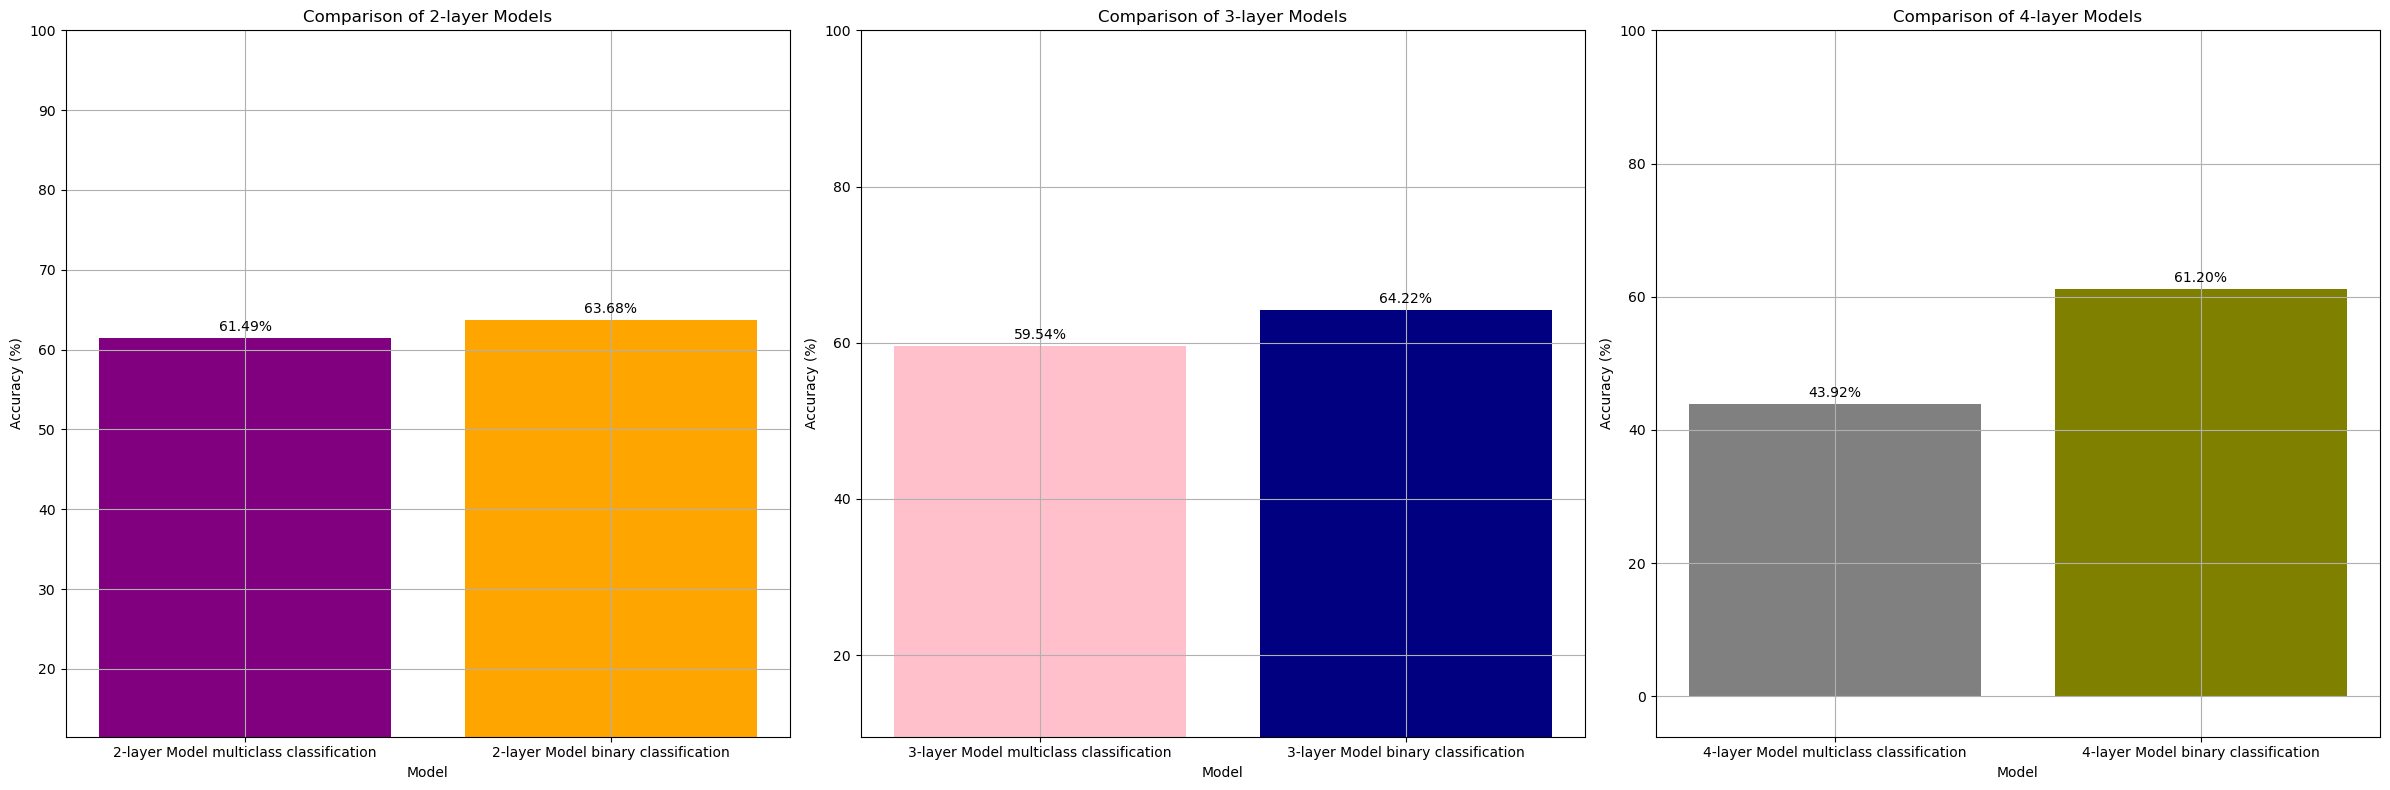

In [414]:
import matplotlib.pyplot as plt

accuracy_scores_1 = {
    '2-layer Model multiclass classification': accuracy_2layer_multiclass,
    '2-layer Model binary classification': accuracy_2layer,
}
accuracy_scores_2 = {
    '3-layer Model multiclass classification': accuracy_3layer_multiclass,
    '3-layer Model binary classification': accuracy_3layer,
}
accuracy_scores_3 = {
    '4-layer Model multiclass classification': accuracy_4layer_multiclass,
    '4-layer Model binary classification': accuracy_4layer,
}

colors = ["purple", "orange", "pink", "navy", "gray", "olive"]

def plot_accuracy_graph(ax, accuracy_scores, title, colors):
    models = list(accuracy_scores.keys())
    accuracies = [100 * accuracy_scores[model] for model in models]     
    ax.bar(models, accuracies, color=colors)
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim([min(accuracies) - 50, 100])    
    for i, v in enumerate(accuracies):
        ax.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

fig, axs = plt.subplots(1, 3, figsize=(24, 8)) 
plot_accuracy_graph(axs[0], accuracy_scores_1, 'Comparison of 2-layer Models', colors[:2])
plot_accuracy_graph(axs[1], accuracy_scores_2, 'Comparison of 3-layer Models', colors[2:4])
plot_accuracy_graph(axs[2], accuracy_scores_3, 'Comparison of 4-layer Models', colors[4:6])

plt.tight_layout()
plt.show()


# Using CNN for Multi class classification

In [1]:
import os
import pandas as pd

base_directory = 'S_data'

file_paths = []
labels = []

folder_to_label = {
    'cloudy': 0,  
    'desert': 1,  
    'green_area': 2,  
    'water': 3 
}

for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            file_paths.append(file_path)
            labels.append(folder_to_label[folder_name])  

df = pd.DataFrame({
    'file_name': file_paths,
    'label': labels
})

print(df.head())
print(f'Total rows: {df.shape[0]}')


                       file_name  label
0  S_data/cloudy/train_17406.jpg      0
1  S_data/cloudy/train_23953.jpg      0
2  S_data/cloudy/train_34585.jpg      0
3  S_data/cloudy/train_16042.jpg      0
4  S_data/cloudy/train_18084.jpg      0
Total rows: 5631


In [2]:
dataset = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
dataset.head()

file_name  label
0  S_data/green_area/Forest_2848.jpg      2
1       S_data/water/SeaLake_747.jpg      3
2   S_data/green_area/Forest_210.jpg      2
3      S_data/water/SeaLake_1519.jpg      3
4  S_data/green_area/Forest_2072.jpg      2

In [4]:
X_dataset = dataset["file_name"].values
Y_dataset = dataset["label"].values

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test_valid, y_train, y_test_valid = train_test_split(X_dataset, Y_dataset, test_size=0.3)

In [7]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test_valid, y_test_valid, test_size=0.5)

In [8]:

from PIL import Image

def process_image(image_paths, target_size=(224, 224)):
    processed_images = []
    for path in image_paths:
        img = Image.open(path)
        img = img.resize(target_size)
        img = img.convert("RGB")  # Ensure the image is in RGB mode
        img_array = np.array(img)
        img_array = img_array.astype(np.uint8)  # Convert the dtype to uint8
        processed_images.append(img_array)
    return processed_images

In [9]:
import numpy as np
x_train_image = process_image(x_train)
x_valid_image = process_image(x_valid)
x_test_image = process_image(x_test)

In [10]:
x_train_image = np.array(x_train_image)
x_valid_image = np.array(x_valid_image)
x_test_image = np.array(x_test_image)

In [11]:
x_train_image.shape, y_train.shape, x_valid_image.shape, y_valid.shape, x_test_image.shape, y_test.shape

((3941, 224, 224, 3),
 (3941,),
 (845, 224, 224, 3),
 (845,),
 (845, 224, 224, 3),
 (845,))

In [12]:
x_train_image = x_train_image.astype(float)
x_valid_image = x_valid_image.astype(float)
x_test_image = x_test_image.astype(float)

In [13]:
x_train_image = x_train_image/255
x_valid_image = x_valid_image/255
x_test_image = x_test_image/255

In [14]:
Input_shape = x_train_image[0].shape
Input_shape

(224, 224, 3)

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [16]:
model = Sequential()
model.add(Conv2D(filters=12, kernel_size=(5, 5), activation='relu', input_shape=Input_shape))
model.add(MaxPooling2D())

model.add(Conv2D(filters=8, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(filters=4, kernel_size=(5, 5), activation='relu'))
model.add(Dropout(0.3))

model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

In [17]:
model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 12)      912       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 12)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 8)       2408      
                                                                 
 conv2d_2 (Conv2D)           (None, 102, 102, 4)       804       
                                                                 
 dropout (Dropout)           (None, 102, 102, 4)       0         
                                                                 
 average_pooling2d (Average  (None, 51, 51, 4)         0         
 Pooling2D)                                             

In [19]:
result = model.fit(x_train_image,
                        y_train,
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        validation_data = (x_valid_image,y_valid))

Epoch 1/50
62/62 [==============================] - 50s 793ms/step - loss: 1.2483 - accuracy: 0.4372 - val_loss: 1.1836 - val_accuracy: 0.4438
Epoch 2/50
62/62 [==============================] - 46s 738ms/step - loss: 1.1672 - accuracy: 0.4707 - val_loss: 1.1403 - val_accuracy: 0.4450
Epoch 3/50
62/62 [==============================] - 44s 713ms/step - loss: 1.1489 - accuracy: 0.4750 - val_loss: 1.1182 - val_accuracy: 0.4817
Epoch 4/50
62/62 [==============================] - 43s 701ms/step - loss: 1.0680 - accuracy: 0.5077 - val_loss: 0.8085 - val_accuracy: 0.4663
Epoch 5/50
62/62 [==============================] - 42s 674ms/step - loss: 0.6803 - accuracy: 0.6224 - val_loss: 0.7094 - val_accuracy: 0.6379
Epoch 6/50
62/62 [==============================] - 42s 681ms/step - loss: 0.6342 - accuracy: 0.6640 - val_loss: 0.6025 - val_accuracy: 0.6781
Epoch 7/50
62/62 [==============================] - 42s 683ms/step - loss: 0.5903 - accuracy: 0.6770 - val_loss: 0.4719 - val_accuracy: 0.7006

In [20]:
multiclass_score = model.evaluate(x_test_image, y_test,verbose=0)
print('Test Accuracy : {:.4f}'.format(multiclass_score[1]))
print('test Loss : {:.4f}'.format(multiclass_score[0]))

Test Accuracy : 0.6876
test Loss : 0.4709


In [21]:
predicted_probabilities = model.predict(x_test_image)
predicted_classes = np.argmax(predicted_probabilities, axis=-1)
predicted_classes

27/27 [==============================] - 2s 51ms/step


array([2, 0, 0, 0, 3, 3, 0, 2, 1, 2, 3, 1, 2, 1, 2, 0, 0, 1, 0, 2, 3, 2,
       0, 1, 1, 0, 2, 0, 3, 0, 1, 1, 0, 2, 2, 3, 1, 2, 2, 0, 2, 3, 3, 0,
       2, 3, 1, 2, 3, 0, 3, 2, 2, 1, 1, 1, 2, 1, 2, 0, 3, 3, 2, 0, 0, 1,
       1, 2, 0, 2, 2, 1, 3, 3, 3, 2, 1, 2, 3, 2, 3, 0, 1, 1, 2, 2, 2, 2,
       3, 0, 2, 0, 3, 2, 0, 0, 0, 3, 3, 2, 1, 0, 2, 1, 1, 0, 2, 3, 0, 2,
       2, 0, 3, 1, 3, 1, 1, 0, 0, 2, 2, 1, 1, 3, 2, 2, 0, 0, 3, 2, 3, 2,
       2, 1, 2, 1, 0, 2, 0, 1, 2, 1, 0, 2, 1, 2, 2, 3, 0, 0, 0, 3, 0, 2,
       1, 2, 1, 2, 2, 0, 2, 2, 1, 2, 1, 3, 2, 0, 0, 2, 0, 3, 1, 0, 2, 3,
       2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 1, 2, 0, 3, 0, 0, 2, 2, 2, 1, 2, 2,
       1, 0, 2, 0, 1, 1, 3, 2, 2, 2, 2, 3, 1, 0, 2, 1, 2, 2, 2, 0, 2, 1,
       2, 0, 2, 0, 2, 1, 3, 2, 0, 2, 1, 2, 2, 0, 3, 2, 1, 2, 1, 2, 2, 1,
       1, 3, 0, 3, 2, 0, 2, 2, 1, 3, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1,
       2, 2, 3, 1, 2, 2, 0, 3, 1, 2, 2, 3, 1, 2, 2, 3, 2, 0, 0, 0, 0, 1,
       3, 2, 2, 2, 3, 0, 2, 0, 1, 0, 2, 1, 1, 2, 0,

<Axes: >

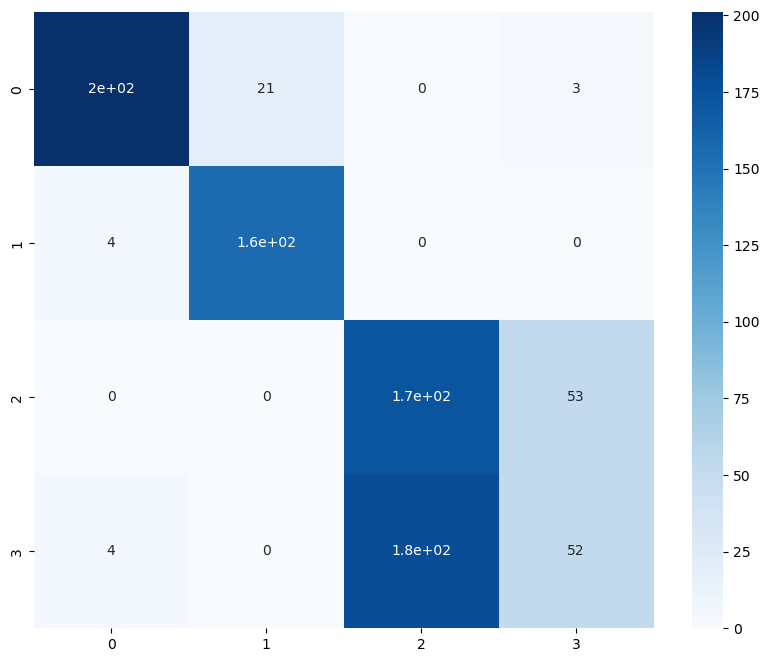

In [26]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_multilayer = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (10,8))
import seaborn as sns
sns.heatmap(cm_multilayer, annot=True, cmap='Blues')

# using CNN for Binary classification

# Binary Classification using CNN with large dataset

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [3]:
import os
import pandas as pd

base_directory = 'Data'

file_paths = []
labels = []

# Define your folder to label mapping
folder_to_label = {
    'Cat': 0,
    'Dog': 1,
}

# List of image extensions you want to allow
allowed_extensions = ['.jpg', '.JPEG', '.png']

for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            # Check if the file extension is in the list of allowed extensions
            if any(file.lower().endswith(ext) for ext in allowed_extensions):
                file_path = os.path.join(folder_path, file)
                file_paths.append(file_path)
                labels.append(folder_to_label[folder_name])

# Create a DataFrame from the lists
df = pd.DataFrame({
    'file_name': file_paths,
    'label': labels
})

print(df.head())
print(f'Total rows: {df.shape[0]}')


           file_name  label
0  Data/Cat/9733.jpg      0
1    Data/Cat/63.jpg      0
2  Data/Cat/6400.jpg      0
3   Data/Cat/823.jpg      0
4  Data/Cat/4217.jpg      0
Total rows: 24998


In [4]:
dataset = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
dataset.head()

file_name  label
0   Data/Cat/4095.jpg      0
1  Data/Dog/12138.jpg      1
2   Data/Cat/6555.jpg      0
3   Data/Dog/7127.jpg      1
4    Data/Dog/633.jpg      1

In [6]:
X_dataset = dataset["file_name"].values
Y_dataset = dataset["label"].values

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test_valid, y_train, y_test_valid = train_test_split(X_dataset[:5000], Y_dataset[:5000], test_size=0.3)

In [8]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test_valid, y_test_valid, test_size=0.5)

In [9]:

from PIL import Image

def process_image(image_paths, target_size=(224, 224)):
    processed_images = []
    for path in image_paths:
        img = Image.open(path)
        img = img.resize(target_size)
        img = img.convert("RGB")  # Ensure the image is in RGB mode
        img_array = np.array(img)
        img_array = img_array.astype(np.uint8)  # Convert the dtype to uint8
        processed_images.append(img_array)
    return processed_images

In [10]:
import numpy as np
x_train_image = process_image(x_train)
x_valid_image = process_image(x_valid)
x_test_image = process_image(x_test)

In [11]:
x_train_image = np.array(x_train_image)
x_valid_image = np.array(x_valid_image)
x_test_image = np.array(x_test_image)

In [12]:
x_train_image.shape, y_train.shape, x_valid_image.shape, y_valid.shape, x_test_image.shape, y_test.shape

((3500, 224, 224, 3),
 (3500,),
 (750, 224, 224, 3),
 (750,),
 (750, 224, 224, 3),
 (750,))

In [13]:
x_train_image = x_train_image.astype(float)
x_valid_image = x_valid_image.astype(float)
x_test_image = x_test_image.astype(float)

In [14]:
x_train_image = x_train_image/255
x_valid_image = x_valid_image/255
x_test_image = x_test_image/255

In [15]:
Input_shape = x_train_image[0].shape
Input_shape

(224, 224, 3)

In [16]:
model1 = Sequential()
model1.add(Conv2D(filters=12, kernel_size=(5, 5), activation='relu', input_shape=Input_shape))
model1.add(MaxPooling2D())

model1.add(Conv2D(filters=8, kernel_size=(5, 5), activation='relu'))
model1.add(Conv2D(filters=4, kernel_size=(5, 5), activation='relu'))
model1.add(Dropout(0.3))

model1.add(AveragePooling2D())
model1.add(Flatten())
model1.add(Dense(units=16, activation='relu'))
model1.add(Dense(units=2, activation='softmax'))

In [17]:
import tensorflow as tf
import tensorflow_hub as hub

print("Tensorflow version", tf.__version__)
print("Tensorflow hub version", hub.__version__)

Tensorflow version 2.13.0
Tensorflow hub version 0.15.0
not available


In [18]:
model1.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 12)      912       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 12)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 8)       2408      
                                                                 
 conv2d_2 (Conv2D)           (None, 102, 102, 4)       804       
                                                                 
 dropout (Dropout)           (None, 102, 102, 4)       0         
                                                                 
 average_pooling2d (Average  (None, 51, 51, 4)         0         
 Pooling2D)                                             

In [20]:
binary_classification_largedataset = model1.fit(x_train_image,
                        y_train,
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        validation_data = (x_valid_image,y_valid))

Epoch 1/50
55/55 [==============================] - 42s 750ms/step - loss: 0.6946 - accuracy: 0.5154 - val_loss: 0.6892 - val_accuracy: 0.5493
Epoch 2/50
55/55 [==============================] - 36s 658ms/step - loss: 0.6834 - accuracy: 0.5780 - val_loss: 0.6792 - val_accuracy: 0.5547
Epoch 3/50
55/55 [==============================] - 36s 653ms/step - loss: 0.6565 - accuracy: 0.6189 - val_loss: 0.6763 - val_accuracy: 0.5600
Epoch 4/50
55/55 [==============================] - 36s 652ms/step - loss: 0.6234 - accuracy: 0.6551 - val_loss: 0.6858 - val_accuracy: 0.6027
Epoch 5/50
55/55 [==============================] - 35s 643ms/step - loss: 0.5616 - accuracy: 0.7083 - val_loss: 0.6989 - val_accuracy: 0.5613
Epoch 6/50
55/55 [==============================] - 36s 654ms/step - loss: 0.4830 - accuracy: 0.7671 - val_loss: 0.8026 - val_accuracy: 0.5933
Epoch 7/50
55/55 [==============================] - 36s 652ms/step - loss: 0.3608 - accuracy: 0.8457 - val_loss: 1.0055 - val_accuracy: 0.6000

In [21]:
binary_large_dataset_score = model1.evaluate(x_test_image, y_test,verbose=0)
print('Test Accuracy : {:.4f}'.format(binary_large_dataset_score[1]))
print('test Loss : {:.4f}'.format(binary_large_dataset_score[0]))

Test Accuracy : 0.5987
test Loss : 3.9719


In [22]:
predicted_probabilities = model1.predict(x_test_image)
predicted_classes = np.argmax(predicted_probabilities, axis=-1)
predicted_classes

24/24 [==============================] - 2s 58ms/step


array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,

<Axes: >

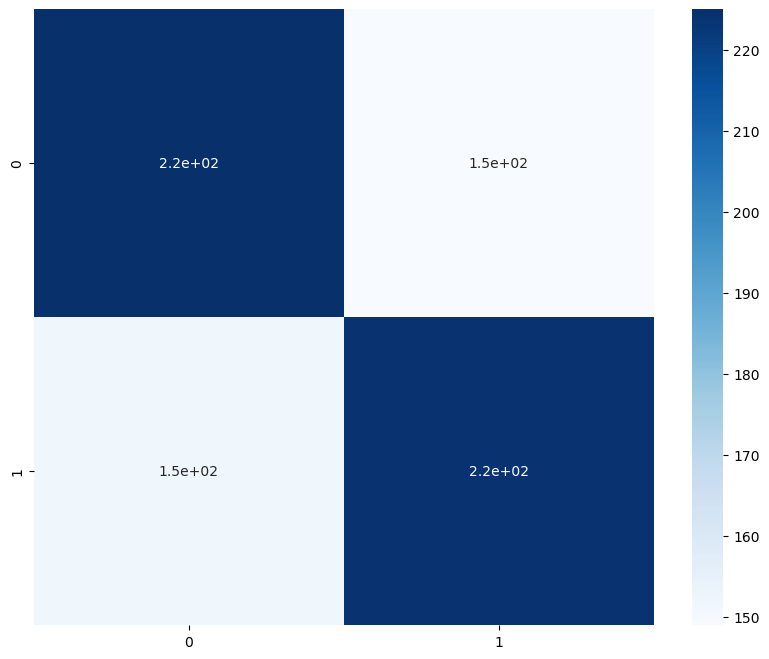

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_binary_large_dataset = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (10,8))

sns.heatmap(cm_binary_large_dataset, annot=True, cmap='Blues')

# Binary Classification using CNN with small dataset

In [24]:
import os
import pandas as pd

base_directory = 'M_data'

file_paths = []
labels = []

# Define your folder to label mapping
folder_to_label = {
    'Cat': 0,
    'Dog': 1,
}

# List of image extensions you want to allow
allowed_extensions = ['.jpg', '.JPEG', '.png']

for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            # Check if the file extension is in the list of allowed extensions
            if any(file.lower().endswith(ext) for ext in allowed_extensions):
                file_path = os.path.join(folder_path, file)
                file_paths.append(file_path)
                labels.append(folder_to_label[folder_name])

# Create a DataFrame from the lists
df = pd.DataFrame({
    'file_name': file_paths,
    'label': labels
})

print(df.head())
print(f'Total rows: {df.shape[0]}')


            file_name  label
0   M_data/Cat/63.jpg      0
1  M_data/Cat/823.jpg      0
2  M_data/Cat/189.jpg      0
3   M_data/Cat/77.jpg      0
4  M_data/Cat/837.jpg      0
Total rows: 1999


In [25]:
dataset = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [26]:
X_dataset = dataset["file_name"].values
Y_dataset = dataset["label"].values

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test_valid, y_train, y_test_valid = train_test_split(X_dataset, Y_dataset, test_size=0.3)

In [28]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test_valid, y_test_valid, test_size=0.5)

In [29]:

from PIL import Image

def process_image(image_paths, target_size=(224, 224)):
    processed_images = []
    for path in image_paths:
        img = Image.open(path)
        img = img.resize(target_size)
        img = img.convert("RGB")  # Ensure the image is in RGB mode
        img_array = np.array(img)
        img_array = img_array.astype(np.uint8)  # Convert the dtype to uint8
        processed_images.append(img_array)
    return processed_images

In [30]:
import numpy as np
x_train_image = process_image(x_train)
x_valid_image = process_image(x_valid)
x_test_image = process_image(x_test)

In [31]:
x_train_image = np.array(x_train_image)
x_valid_image = np.array(x_valid_image)
x_test_image = np.array(x_test_image)

In [32]:
x_train_image.shape, y_train.shape, x_valid_image.shape, y_valid.shape, x_test_image.shape, y_test.shape

((1399, 224, 224, 3),
 (1399,),
 (300, 224, 224, 3),
 (300,),
 (300, 224, 224, 3),
 (300,))

In [33]:
x_train_image = x_train_image.astype(float)
x_valid_image = x_valid_image.astype(float)
x_test_image = x_test_image.astype(float)

In [34]:
x_train_image = x_train_image/255
x_valid_image = x_valid_image/255
x_test_image = x_test_image/255

In [35]:
Input_shape = x_train_image[0].shape
Input_shape

(224, 224, 3)

In [44]:
model2 = Sequential()
model2.add(Conv2D(filters=12, kernel_size=(5, 5), activation='relu', input_shape=Input_shape))
model2.add(MaxPooling2D())

model2.add(Conv2D(filters=8, kernel_size=(5, 5), activation='relu'))
model2.add(Conv2D(filters=4, kernel_size=(5, 5), activation='relu'))
model2.add(Dropout(0.3))

model2.add(AveragePooling2D())
model2.add(Flatten())
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=2, activation='softmax'))

In [45]:
model2.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [46]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 220, 220, 12)      912       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 110, 110, 12)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 106, 106, 8)       2408      
                                                                 
 conv2d_11 (Conv2D)          (None, 102, 102, 4)       804       
                                                                 
 dropout_3 (Dropout)         (None, 102, 102, 4)       0         
                                                                 
 average_pooling2d_3 (Avera  (None, 51, 51, 4)         0         
 gePooling2D)                                         

In [47]:
binary_classification_smalldataset = model2.fit(x_train_image,
                        y_train,
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        validation_data = (x_valid_image,y_valid))

Epoch 1/50
22/22 [==============================] - 16s 737ms/step - loss: 0.6959 - accuracy: 0.5054 - val_loss: 0.6903 - val_accuracy: 0.5133
Epoch 2/50
22/22 [==============================] - 15s 687ms/step - loss: 0.6753 - accuracy: 0.5897 - val_loss: 0.6715 - val_accuracy: 0.5567
Epoch 3/50
22/22 [==============================] - 15s 665ms/step - loss: 0.6287 - accuracy: 0.6690 - val_loss: 0.6356 - val_accuracy: 0.6567
Epoch 4/50
22/22 [==============================] - 15s 666ms/step - loss: 0.5626 - accuracy: 0.7248 - val_loss: 0.6310 - val_accuracy: 0.6833
Epoch 5/50
22/22 [==============================] - 15s 689ms/step - loss: 0.5040 - accuracy: 0.7591 - val_loss: 0.7615 - val_accuracy: 0.6000
Epoch 6/50
22/22 [==============================] - 15s 683ms/step - loss: 0.4903 - accuracy: 0.7620 - val_loss: 0.6744 - val_accuracy: 0.6633
Epoch 7/50
22/22 [==============================] - 15s 669ms/step - loss: 0.4036 - accuracy: 0.8199 - val_loss: 0.7984 - val_accuracy: 0.6233

In [48]:
binary_small_dataset_score = model2.evaluate(x_test_image, y_test,verbose=0)
print('Test Accuracy : {:.4f}'.format(binary_small_dataset_score[1]))
print('test Loss : {:.4f}'.format(binary_small_dataset_score[0]))

Test Accuracy : 0.6100
test Loss : 3.2152


In [49]:
predicted_probabilities = model2.predict(x_test_image)
predicted_classes = np.argmax(predicted_probabilities, axis=-1)
predicted_classes

10/10 [==============================] - 1s 53ms/step


array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1])

<Axes: >

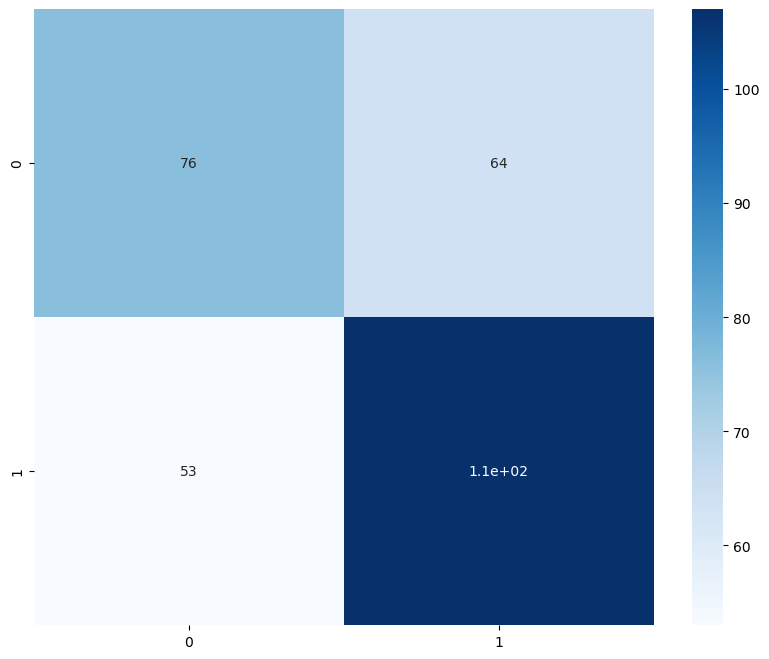

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_binary_small_dataset = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (10,8))

sns.heatmap(cm_binary_small_dataset, annot=True, cmap='Blues')

# Comparing results for Binary classification using CNN with Large and Small Datasets

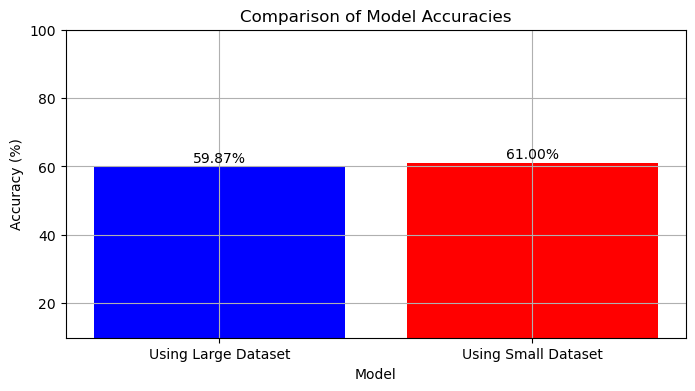

In [52]:
import matplotlib.pyplot as plt


accuracy_scores = {
    'Using Large Dataset': binary_large_dataset_score[1],
    'Using Small Dataset': binary_small_dataset_score[1]
}

# Set up the matplotlib figure
plt.figure(figsize=(8, 4))

# Create a bar chart
models = list(accuracy_scores.keys())
accuracies = [100 * accuracy_scores[model] for model in models]  # Convert to percentages
plt.bar(models, accuracies, color=['blue', 'red'])
plt.grid(True)
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim([min(accuracies) - 50, 100])  

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

plt.show()
